In [1]:
import pandas as pd
import numpy as np
from pycaret.time_series import *
from pycaret.regression import *
import matplotlib.pyplot as plt
import awswrangler as wr
import boto3
from pycaret import *
from sklearn.model_selection import train_test_split
import os
from pycaret.regression import load_model, plot_model
import plotly.express as px
import matplotlib.pyplot as plt
import logging

In [2]:
boto3.setup_default_session(profile_name='anthony_garove_fellow_dssgx_24')

bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"

In [3]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df = wr.s3.read_csv(path=path, **kwargs)
    return df
df = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/joined_sensor_weather_visitorcenter_2016-2024.csv"
)
df.head()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
0  2016-01-01 00:00:00                      NaN                       NaN   
1  2016-01-01 01:00:00                      NaN                       NaN   
2  2016-01-01 02:00:00                      NaN                       NaN   
3  2016-01-01 03:00:00                      NaN                       NaN   
4  2016-01-01 04:00:00                      NaN                       NaN   

   Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
0              NaN               NaN           NaN            NaN   
1              NaN               NaN           NaN            NaN   
2              NaN               NaN           NaN            NaN   
3              NaN               NaN           NaN            NaN   
4              NaN               NaN           NaN            NaN   

   Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  ...  \
0                    NaN                     NaN                  NaN  ...   
1                    NaN                     NaN                  NaN  ...   
2                    NaN                     NaN                  NaN  ...   
3                    NaN                     NaN                  NaN  ...   
4                    NaN                     NaN                  NaN  ...   

   Racheldiensthuette_geoeffnet  Waldschmidthaus_geoeffnet  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   

   Falkensteinschutzhaus_geoeffnet  Schwellhaeusl_geoeffnet  Temperatur  \
0                              NaN                      NaN         NaN   
1                              NaN                      NaN         NaN   
2                              NaN                      NaN         NaN   
3                              NaN                      NaN         NaN   
4                              NaN                      NaN         NaN   

   Niederschlagsmenge  Schneehoehe  GS mit  GS max  Total  
0                 NaN          NaN     NaN     NaN    NaN  
1                 NaN          NaN     NaN     NaN    NaN  
2                 NaN          NaN     NaN     NaN    NaN  
3                 NaN          NaN     NaN     NaN    NaN  
4                 NaN          NaN     NaN     NaN    NaN  

[5 rows x 127 columns]

In [4]:
df.tail()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
78907  2024-12-31 19:00:00                      NaN                       NaN   
78908  2024-12-31 20:00:00                      NaN                       NaN   
78909  2024-12-31 21:00:00                      NaN                       NaN   
78910  2024-12-31 22:00:00                      NaN                       NaN   
78911  2024-12-31 23:00:00                      NaN                       NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
78907              NaN               NaN           NaN            NaN   
78908              NaN               NaN           NaN            NaN   
78909              NaN               NaN           NaN            NaN   
78910              NaN               NaN           NaN            NaN   
78911              NaN               NaN           NaN            NaN   

       Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  \
78907                    NaN                     NaN                  NaN   
78908                    NaN                     NaN                  NaN   
78909                    NaN                     NaN                  NaN   
78910                    NaN                     NaN                  NaN   
78911                    NaN                     NaN                  NaN   

       ...  Racheldiensthuette_geoeffnet  Waldschmidthaus_geoeffnet  \
78907  ...                          True                        NaN   
78908  ...                          True                        NaN   
78909  ...                          True                        NaN   
78910  ...                          True                        NaN   
78911  ...                          True                        NaN   

       Falkensteinschutzhaus_geoeffnet  Schwellhaeusl_geoeffnet  Temperatur  \
78907                             True                     True         NaN   
78908                             True                     True         NaN   
78909                             True                     True         NaN   
78910                             True                     True         NaN   
78911                             True                     True         NaN   

       Niederschlagsmenge  Schneehoehe  GS mit  GS max  Total  
78907                 NaN          NaN     NaN     NaN    1.0  
78908                 NaN          NaN     NaN     NaN    1.0  
78909                 NaN          NaN     NaN     NaN    1.0  
78910                 NaN          NaN     NaN     NaN    1.0  
78911                 NaN          NaN     NaN     NaN    1.0  

[5 rows x 127 columns]

In [5]:
# Specify the columns to use
columns_to_use = [
'Time',  'Bayerisch Eisenstein IN',  'Bayerisch Eisenstein OUT',  'Brechhäuslau IN',  'Brechhäuslau OUT',  
'Deffernik IN',  'Deffernik OUT',  'Diensthüttenstraße IN',  'Diensthüttenstraße OUT',  'Felswandergebiet IN',  
'Felswandergebiet OUT',  'Ferdinandsthal IN',  'Ferdinandsthal OUT',  'Fredenbrücke IN',  'Fredenbrücke OUT',  
'Gfäll IN',  'Gfäll OUT',  'Gsenget IN',  'Gsenget OUT',  'Klingenbrunner Wald IN',  'Klingenbrunner Wald OUT',  
'Klosterfilz IN',  'Klosterfilz OUT',  'Racheldiensthütte IN',  'Racheldiensthütte OUT',  'Sagwassersäge IN',  
'Sagwassersäge OUT',  'Scheuereck IN',  'Scheuereck OUT',  'Schillerstraße IN',  'Schillerstraße OUT',  
'Schwarzbachbrücke IN',  'Schwarzbachbrücke OUT',  'Falkenstein 2 OUT',  'Falkenstein 2 IN',  'Lusen 2 IN',  
'Lusen 2 OUT',  'Lusen 3 IN',  'Lusen 3 OUT',  'Waldhausreibe IN',  'Waldhausreibe OUT',  'Waldspielgelände IN',  
'Waldspielgelände OUT',  'Wistlberg IN',  'Wistlberg OUT',  'Bucina MERGED IN',  'Bucina MERGED OUT',  
'Falkenstein 1 MERGED IN',  'Falkenstein 1 MERGED OUT',  'Lusen 1 MERGED IN',  'Lusen 1 MERGED OUT',  
'Trinkwassertalsperre MERGED IN',  'Trinkwassertalsperre MERGED OUT',  
'traffic_abs',  'sum_IN_abs',  'sum_OUT_abs',  'Temperature (°C)',  'Relative Humidity (%)',  
'Precipitation (mm)',  'Wind Speed (km/h)',  'Sunshine Duration (min)',  'Tag',  'Monat',  
'Wochentag',  'Wochenende',  'Jahreszeit',  'Laubfärbung',  'Schulferien_Bayern',  'Schulferien_CZ',  
'Feiertag_Bayern',  'Feiertag_CZ',  'HEH_geoeffnet',  'HZW_geoeffnet',  'WGM_geoeffnet',  
'Lusenschutzhaus_geoeffnet',  'Racheldiensthuette_geoeffnet',  'Falkensteinschutzhaus_geoeffnet',  
'Schwellhaeusl_geoeffnet'
]


In [6]:
# Filter the dataframe to only include the specified columns
df = df[columns_to_use]

# Display the first few rows to ensure the data is loaded correctly
df.head()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
0  2016-01-01 00:00:00                      NaN                       NaN   
1  2016-01-01 01:00:00                      NaN                       NaN   
2  2016-01-01 02:00:00                      NaN                       NaN   
3  2016-01-01 03:00:00                      NaN                       NaN   
4  2016-01-01 04:00:00                      NaN                       NaN   

   Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
0              NaN               NaN           NaN            NaN   
1              NaN               NaN           NaN            NaN   
2              NaN               NaN           NaN            NaN   
3              NaN               NaN           NaN            NaN   
4              NaN               NaN           NaN            NaN   

   Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  ...  \
0                    NaN                     NaN                  NaN  ...   
1                    NaN                     NaN                  NaN  ...   
2                    NaN                     NaN                  NaN  ...   
3                    NaN                     NaN                  NaN  ...   
4                    NaN                     NaN                  NaN  ...   

   Schulferien_CZ  Feiertag_Bayern  Feiertag_CZ  HEH_geoeffnet  HZW_geoeffnet  \
0             NaN              NaN          NaN            NaN            NaN   
1             NaN              NaN          NaN            NaN            NaN   
2             NaN              NaN          NaN            NaN            NaN   
3             NaN              NaN          NaN            NaN            NaN   
4             NaN              NaN          NaN            NaN            NaN   

   WGM_geoeffnet  Lusenschutzhaus_geoeffnet  Racheldiensthuette_geoeffnet  \
0            NaN                        NaN                           NaN   
1            NaN                        NaN                           NaN   
2            NaN                        NaN                           NaN   
3            NaN                        NaN                           NaN   
4            NaN                        NaN                           NaN   

   Falkensteinschutzhaus_geoeffnet  Schwellhaeusl_geoeffnet  
0                              NaN                      NaN  
1                              NaN                      NaN  
2                              NaN                      NaN  
3                              NaN                      NaN  
4                              NaN                      NaN  

[5 rows x 78 columns]

In [7]:
# CREATE NEW REGION VARIABLE

# Remove MERGED from column names with this unnecessary label
df.columns = df.columns.str.replace(' MERGED', '', regex=False)

# Create a dictionary for mapping
location_mapping = {
    'Bayerisch Eisenstein IN': 'Falkenstein-Schwellhäusl',
    'Bayerisch Eisenstein OUT': 'Falkenstein-Schwellhäusl', 
    'Brechhäuslau IN': 'Falkenstein-Schwellhäusl', 
    'Brechhäuslau OUT': 'Falkenstein-Schwellhäusl', 
    'Deffernik IN': 'Falkenstein-Schwellhäusl',
    'Deffernik OUT': 'Falkenstein-Schwellhäusl',
    'Falkenstein 1 IN': 'Nationalparkzentrum Falkenstein', 
    'Falkenstein 1 OUT': 'Nationalparkzentrum Falkenstein',
    'Falkenstein 2 IN': 'Nationalparkzentrum Falkenstein', 
    'Falkenstein 2 OUT': 'Nationalparkzentrum Falkenstein',
    'Ferdinandsthal IN': 'Falkenstein-Schwellhäusl', 
    'Ferdinandsthal OUT': 'Falkenstein-Schwellhäusl', 
    'Gsenget IN': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Gsenget OUT': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Scheuereck IN': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Scheuereck OUT': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Schillerstraße IN': 'Falkenstein-Schwellhäusl', 
    'Schillerstraße OUT': 'Falkenstein-Schwellhäusl', 
    'Trinkwassertalsperre IN': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Trinkwassertalsperre OUT': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Bucina IN': 'Lusen-Mauth-Finsterau',
    'Bucina OUT': 'Lusen-Mauth-Finsterau', 
    'Diensthüttenstraße IN': 'Rachel-Spiegelau', 
    'Diensthüttenstraße OUT': 'Rachel-Spiegelau',
    'Felswandergebiet IN': 'Lusen-Mauth-Finsterau', 
    'Felswandergebiet OUT': 'Lusen-Mauth-Finsterau',
    'Fredenbrücke IN': 'Lusen-Mauth-Finsterau', 
    'Fredenbrücke OUT': 'Lusen-Mauth-Finsterau', 
    'Gfäll IN': 'Rachel-Spiegelau', 
    'Gfäll OUT': 'Rachel-Spiegelau', 
    'Klingenbrunner Wald IN': 'Rachel-Spiegelau', 
    'Klingenbrunner Wald OUT': 'Rachel-Spiegelau', 
    'Klosterfilz IN': 'Rachel-Spiegelau', 
    'Klosterfilz OUT': 'Rachel-Spiegelau',
    'Lusen 1 IN': 'Nationalparkzentrum Lusen', 
    'Lusen 1 OUT': 'Nationalparkzentrum Lusen', 
    'Lusen 2 IN': 'Nationalparkzentrum Lusen',
    'Lusen 2 OUT': 'Nationalparkzentrum Lusen', 
    'Lusen 3 IN': 'Nationalparkzentrum Lusen', 
    'Lusen 3 OUT': 'Nationalparkzentrum Lusen',
    'Racheldiensthütte IN': 'Rachel-Spiegelau', 
    'Racheldiensthütte OUT': 'Rachel-Spiegelau',
    'Schwarzbachbrücke IN': 'Lusen-Mauth-Finsterau', 
    'Schwarzbachbrücke OUT': 'Lusen-Mauth-Finsterau', 
    'Waldhausreibe IN': 'Lusen-Mauth-Finsterau', 
    'Waldhausreibe OUT': 'Lusen-Mauth-Finsterau', 
    'Waldspielgelände IN': 'Rachel-Spiegelau', 
    'Waldspielgelände OUT': 'Rachel-Spiegelau', 
    'Wistlberg IN': 'Lusen-Mauth-Finsterau', 
    'Wistlberg OUT': 'Lusen-Mauth-Finsterau', 
    'Sagwassersäge IN': 'Lusen-Mauth-Finsterau',
    'Sagwassersäge OUT': 'Lusen-Mauth-Finsterau'
}

# Extract unique regions
regions = set(location_mapping.values())

# Iterate over each region
for region in regions:
    # Filter the keys in location_mapping that belong to the current region
    region_in_columns = [col for col in location_mapping if location_mapping[col] == region and ' IN' in col]
    region_out_columns = [col for col in location_mapping if location_mapping[col] == region and ' OUT' in col]

    # Sum the values for all IN columns of the current region, while retaining NaN where all are NaN
    df[f'{region} IN'] = df[region_in_columns].sum(axis=1, min_count=1)
    
    # Sum the values for all OUT columns of the current region, while retaining NaN where all are NaN
    df[f'{region} OUT'] = df[region_out_columns].sum(axis=1, min_count=1)

# Display the updated DataFrame
df.tail()

# EXPLANATION OF LOOPING FUNCTION BELOW
#min_count=1 in sum():
#The sum(axis=1, min_count=1) method ensures that if all values being summed are NaN, the result will be NaN.
#If at least one value is not NaN, it will compute the sum, ignoring the NaN values.
#Explanation:
#min_count=1: This parameter in the sum() function specifies the minimum number of non-NaN values required to perform the summation. If the count of non-NaN values is less than min_count, the result will be NaN.
#Result: The DataFrame will have the new region columns that sum the sensors while retaining NaN if all sensors in a region are NaN for a given row.

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
78907  2024-12-31 19:00:00                      NaN                       NaN   
78908  2024-12-31 20:00:00                      NaN                       NaN   
78909  2024-12-31 21:00:00                      NaN                       NaN   
78910  2024-12-31 22:00:00                      NaN                       NaN   
78911  2024-12-31 23:00:00                      NaN                       NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
78907              NaN               NaN           NaN            NaN   
78908              NaN               NaN           NaN            NaN   
78909              NaN               NaN           NaN            NaN   
78910              NaN               NaN           NaN            NaN   
78911              NaN               NaN           NaN            NaN   

       Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  \
78907                    NaN                     NaN                  NaN   
78908                    NaN                     NaN                  NaN   
78909                    NaN                     NaN                  NaN   
78910                    NaN                     NaN                  NaN   
78911                    NaN                     NaN                  NaN   

       ...  Nationalparkzentrum Lusen IN  Nationalparkzentrum Lusen OUT  \
78907  ...                           NaN                            NaN   
78908  ...                           NaN                            NaN   
78909  ...                           NaN                            NaN   
78910  ...                           NaN                            NaN   
78911  ...                           NaN                            NaN   

       Nationalparkzentrum Falkenstein IN  \
78907                                 NaN   
78908                                 NaN   
78909                                 NaN   
78910                                 NaN   
78911                                 NaN   

       Nationalparkzentrum Falkenstein OUT  Lusen-Mauth-Finsterau IN  \
78907                                  NaN                       NaN   
78908                                  NaN                       NaN   
78909                                  NaN                       NaN   
78910                                  NaN                       NaN   
78911                                  NaN                       NaN   

       Lusen-Mauth-Finsterau OUT  Falkenstein-Schwellhäusl IN  \
78907                        NaN                          NaN   
78908                        NaN                          NaN   
78909                        NaN                          NaN   
78910                        NaN                          NaN   
78911                        NaN                          NaN   

       Falkenstein-Schwellhäusl OUT  Rachel-Spiegelau IN  Rachel-Spiegelau OUT  
78907                           NaN                  NaN                   NaN  
78908                           NaN                  NaN                   NaN  
78909                           NaN                  NaN                   NaN  
78910                           NaN                  NaN                   NaN  
78911                           NaN                  NaN                   NaN  

[5 rows x 90 columns]

In [8]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df = wr.s3.read_csv(path=path, **kwargs)
    return df
df_newfeatures = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/holidays_deltaweather_features_df.csv"
)
df_newfeatures.head()

Unnamed: 0                 Time  Bayerisch Eisenstein IN  \
0           0  2017-01-01 00:00:00                      NaN   
1           1  2017-01-01 01:00:00                      NaN   
2           2  2017-01-01 02:00:00                      NaN   
3           3  2017-01-01 03:00:00                      NaN   
4           4  2017-01-01 04:00:00                      NaN   

   Bayerisch Eisenstein OUT  Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
0                       NaN            257.0             412.0           NaN   
1                       NaN              NaN               NaN           NaN   
2                       NaN              NaN               NaN           NaN   
3                       NaN              NaN               NaN           NaN   
4                       NaN              NaN               NaN           NaN   

   Deffernik OUT  Diensthüttenstraße IN  Diensthüttenstraße OUT  ...  GS max  \
0            NaN                    NaN                     NaN  ...   345.0   
1            NaN                    NaN                     NaN  ...   345.0   
2            NaN                    NaN                     NaN  ...   345.0   
3            NaN                    NaN                     NaN  ...   345.0   
4            NaN                    NaN                     NaN  ...   345.0   

   Total        Date  Distance_to_Nearest_Holiday_Bayern  \
0    1.0  2017-01-01                                   0   
1    1.0  2017-01-01                                   0   
2    1.0  2017-01-01                                   0   
3    1.0  2017-01-01                                   0   
4    1.0  2017-01-01                                   0   

   Distance_to_Nearest_Holiday_CZ  ZScore_Daily_Max_Temperature (°C)  \
0                               0                                NaN   
1                               0                                NaN   
2                               0                                NaN   
3                               0                                NaN   
4                               0                                NaN   

   ZScore_Daily_Max_Relative Humidity (%)  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   ZScore_Daily_Max_Precipitation (mm)  ZScore_Daily_Max_Wind Speed (km/h)  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                  NaN                                 NaN   

   ZScore_Daily_Max_Sunshine Duration (min)  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4                                       NaN  

[5 rows x 136 columns]

In [9]:
df['Time'] = pd.to_datetime(df['Time'])
df_newfeatures['Time'] = pd.to_datetime(df_newfeatures['Time'])

# Step 2: Select the columns you want to add from df_newfeatures
columns_to_add = [
    'ZScore_Daily_Max_Temperature (°C)',
    'ZScore_Daily_Max_Relative Humidity (%)',
    'ZScore_Daily_Max_Precipitation (mm)',
    'ZScore_Daily_Max_Wind Speed (km/h)',
    'ZScore_Daily_Max_Sunshine Duration (min)',
    'Distance_to_Nearest_Holiday_Bayern',
    'Distance_to_Nearest_Holiday_CZ'
]

# Ensure that the selected columns exist in df_newfeatures
selected_columns = [col for col in columns_to_add if col in df_newfeatures.columns]

# Step 3: Merge df with df_newfeatures on 'Time' and add the selected columns
df = pd.merge(df, df_newfeatures[['Time'] + selected_columns], on='Time', how='left')

# Optionally, you can display the merged dataframe
df.tail()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
78907 2024-12-31 19:00:00                      NaN                       NaN   
78908 2024-12-31 20:00:00                      NaN                       NaN   
78909 2024-12-31 21:00:00                      NaN                       NaN   
78910 2024-12-31 22:00:00                      NaN                       NaN   
78911 2024-12-31 23:00:00                      NaN                       NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
78907              NaN               NaN           NaN            NaN   
78908              NaN               NaN           NaN            NaN   
78909              NaN               NaN           NaN            NaN   
78910              NaN               NaN           NaN            NaN   
78911              NaN               NaN           NaN            NaN   

       Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  \
78907                    NaN                     NaN                  NaN   
78908                    NaN                     NaN                  NaN   
78909                    NaN                     NaN                  NaN   
78910                    NaN                     NaN                  NaN   
78911                    NaN                     NaN                  NaN   

       ...  Falkenstein-Schwellhäusl OUT  Rachel-Spiegelau IN  \
78907  ...                           NaN                  NaN   
78908  ...                           NaN                  NaN   
78909  ...                           NaN                  NaN   
78910  ...                           NaN                  NaN   
78911  ...                           NaN                  NaN   

       Rachel-Spiegelau OUT  ZScore_Daily_Max_Temperature (°C)  \
78907                   NaN                                NaN   
78908                   NaN                                NaN   
78909                   NaN                                NaN   
78910                   NaN                                NaN   
78911                   NaN                                NaN   

       ZScore_Daily_Max_Relative Humidity (%)  \
78907                                     NaN   
78908                                     NaN   
78909                                     NaN   
78910                                     NaN   
78911                                     NaN   

       ZScore_Daily_Max_Precipitation (mm)  \
78907                                  NaN   
78908                                  NaN   
78909                                  NaN   
78910                                  NaN   
78911                                  NaN   

       ZScore_Daily_Max_Wind Speed (km/h)  \
78907                                 NaN   
78908                                 NaN   
78909                                 NaN   
78910                                 NaN   
78911                                 NaN   

       ZScore_Daily_Max_Sunshine Duration (min)  \
78907                                       NaN   
78908                                       NaN   
78909                                       NaN   
78910                                       NaN   
78911                                       NaN   

       Distance_to_Nearest_Holiday_Bayern  Distance_to_Nearest_Holiday_CZ  
78907                                 0.0                             5.0  
78908                                 0.0                             5.0  
78909                                 0.0                             5.0  
78910                                 0.0                             5.0  
78911                                 0.0                             5.0  

[5 rows x 97 columns]

In [10]:
# Specify the data types
dtype_dict = {
    'Time': 'datetime64[ns]',
    'traffic_abs': 'float64',
    'Temperature (°C)': 'float64',
    'Relative Humidity (%)': 'float64',
    'Precipitation (mm)': 'float64',
    'Wind Speed (km/h)': 'float64',
    'Sunshine Duration (min)': 'float64',
    'Monat': 'float64',
    'Wochentag': 'category',
    'Wochenende': 'category',
    'Jahreszeit': 'category',
    'Laubfärbung': 'category',
    'Feiertag_Bayern': 'category',
    'Feiertag_CZ': 'category',
    'HEH_geoeffnet': 'category',
    'HZW_geoeffnet': 'category',
    'WGM_geoeffnet': 'category',
    'Lusenschutzhaus_geoeffnet': 'category',
    'Racheldiensthuette_geoeffnet': 'category',
    'Falkensteinschutzhaus_geoeffnet': 'category',
    'Schwellhaeusl_geoeffnet': 'category',
    'Schulferien_Bayern': 'category',
    'Schulferien_CZ': 'category',
    'sum_IN_abs': 'float64',
    'sum_OUT_abs': 'float64',
    'Falkenstein-Schwellhäusl IN': 'float64',
    'Rachel-Spiegelau IN': 'float64',
    'Nationalparkzentrum Falkenstein IN': 'float64',
    'Nationalparkzentrum Lusen IN': 'float64',
    'Lusen-Mauth-Finsterau IN': 'float64',
    'Scheuereck-Schachten-Trinkwassertalsperre IN': 'float64',
    'Falkenstein-Schwellhäusl OUT': 'float64',
    'Rachel-Spiegelau OUT': 'float64',
    'Nationalparkzentrum Falkenstein OUT': 'float64',
    'Nationalparkzentrum Lusen OUT': 'float64',
    'Lusen-Mauth-Finsterau OUT': 'float64',
    'Scheuereck-Schachten-Trinkwassertalsperre OUT': 'float64',
    'Bayerisch Eisenstein IN': 'float64',
    'Bayerisch Eisenstein OUT': 'float64',
    'Brechhäuslau IN': 'float64',
    'Brechhäuslau OUT': 'float64',
    'Deffernik IN': 'float64',
    'Deffernik OUT': 'float64',
    'Diensthüttenstraße IN': 'float64',
    'Diensthüttenstraße OUT': 'float64',
    'Felswandergebiet IN': 'float64',
    'Felswandergebiet OUT': 'float64',
    'Ferdinandsthal IN': 'float64',
    'Ferdinandsthal OUT': 'float64',
    'Fredenbrücke IN': 'float64',
    'Fredenbrücke OUT': 'float64',
    'Gfäll IN': 'float64',
    'Gfäll OUT': 'float64',
    'Gsenget IN': 'float64',
    'Gsenget OUT': 'float64',
    'Klingenbrunner Wald IN': 'float64',
    'Klingenbrunner Wald OUT': 'float64',
    'Klosterfilz IN': 'float64',
    'Klosterfilz OUT': 'float64',
    'Racheldiensthütte IN': 'float64',
    'Racheldiensthütte OUT': 'float64',
    'Sagwassersäge IN': 'float64',
    'Sagwassersäge OUT': 'float64',
    'Scheuereck IN': 'float64',
    'Scheuereck OUT': 'float64',
    'Schillerstraße IN': 'float64',
    'Schillerstraße OUT': 'float64',
    'Schwarzbachbrücke IN': 'float64',
    'Schwarzbachbrücke OUT': 'float64',
    'Falkenstein 2 OUT': 'float64',
    'Falkenstein 2 IN': 'float64',
    'Lusen 2 IN': 'float64',
    'Lusen 2 OUT': 'float64',
    'Lusen 3 IN': 'float64',
    'Lusen 3 OUT': 'float64',
    'Waldhausreibe IN': 'float64',
    'Waldhausreibe OUT': 'float64',
    'Waldspielgelände IN': 'float64',
    'Waldspielgelände OUT': 'float64',
    'Wistlberg IN': 'float64',
    'Wistlberg OUT': 'float64',
    'Bucina IN': 'float64',
    'Bucina OUT': 'float64',
    'Falkenstein 1 IN': 'float64',
    'Falkenstein 1 OUT': 'float64',
    'Lusen 1 IN': 'float64',
    'Lusen 1 OUT': 'float64',
    'Trinkwassertalsperre IN': 'float64',
    'Trinkwassertalsperre OUT': 'float64',
    'ZScore_Daily_Max_Temperature (°C)': 'float64',
    'ZScore_Daily_Max_Relative Humidity (%)': 'float64',
    'ZScore_Daily_Max_Precipitation (mm)': 'float64',
    'ZScore_Daily_Max_Wind Speed (km/h)': 'float64',
    'ZScore_Daily_Max_Sunshine Duration (min)': 'float64',
    'Distance_to_Nearest_Holiday_Bayern': 'float64',
    'Distance_to_Nearest_Holiday_CZ': 'float64'
}

# Apply data types
df = df.astype(dtype_dict)

# Set 'Time' column as index
df.set_index('Time', inplace=True)

# Add 'Hour' column based on the index
df["Hour"] = df.index.hour

# Convert 'Hour' to categorical
df['Hour'] = pd.Categorical(df['Hour'])

# Reset the index to make 'Time' a column again
df.reset_index(inplace=True)

df.tail()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
78907 2024-12-31 19:00:00                      NaN                       NaN   
78908 2024-12-31 20:00:00                      NaN                       NaN   
78909 2024-12-31 21:00:00                      NaN                       NaN   
78910 2024-12-31 22:00:00                      NaN                       NaN   
78911 2024-12-31 23:00:00                      NaN                       NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
78907              NaN               NaN           NaN            NaN   
78908              NaN               NaN           NaN            NaN   
78909              NaN               NaN           NaN            NaN   
78910              NaN               NaN           NaN            NaN   
78911              NaN               NaN           NaN            NaN   

       Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  \
78907                    NaN                     NaN                  NaN   
78908                    NaN                     NaN                  NaN   
78909                    NaN                     NaN                  NaN   
78910                    NaN                     NaN                  NaN   
78911                    NaN                     NaN                  NaN   

       ...  Rachel-Spiegelau IN  Rachel-Spiegelau OUT  \
78907  ...                  NaN                   NaN   
78908  ...                  NaN                   NaN   
78909  ...                  NaN                   NaN   
78910  ...                  NaN                   NaN   
78911  ...                  NaN                   NaN   

       ZScore_Daily_Max_Temperature (°C)  \
78907                                NaN   
78908                                NaN   
78909                                NaN   
78910                                NaN   
78911                                NaN   

       ZScore_Daily_Max_Relative Humidity (%)  \
78907                                     NaN   
78908                                     NaN   
78909                                     NaN   
78910                                     NaN   
78911                                     NaN   

       ZScore_Daily_Max_Precipitation (mm)  \
78907                                  NaN   
78908                                  NaN   
78909                                  NaN   
78910                                  NaN   
78911                                  NaN   

       ZScore_Daily_Max_Wind Speed (km/h)  \
78907                                 NaN   
78908                                 NaN   
78909                                 NaN   
78910                                 NaN   
78911                                 NaN   

       ZScore_Daily_Max_Sunshine Duration (min)  \
78907                                       NaN   
78908                                       NaN   
78909                                       NaN   
78910                                       NaN   
78911                                       NaN   

       Distance_to_Nearest_Holiday_Bayern  Distance_to_Nearest_Holiday_CZ  \
78907                                 0.0                             5.0   
78908                                 0.0                             5.0   
78909                                 0.0                             5.0   
78910                                 0.0                             5.0   
78911                                 0.0                             5.0   

       Hour  
78907    19  
78908    20  
78909    21  
78910    22  
78911    23  

[5 rows x 98 columns]

In [11]:
# Ensure 'Time' is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Set 'Time' as the index
df.set_index('Time', inplace=True)

# Slice the data from January 1, 2023, to August 19, 2024
df = df.loc['2023-01-01':'2024-08-19']
# Display the info to check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14328 entries, 2023-01-01 00:00:00 to 2024-08-19 23:00:00
Data columns (total 97 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Bayerisch Eisenstein IN                        14050 non-null  float64 
 1   Bayerisch Eisenstein OUT                       14050 non-null  float64 
 2   Brechhäuslau IN                                14049 non-null  float64 
 3   Brechhäuslau OUT                               14049 non-null  float64 
 4   Deffernik IN                                   13773 non-null  float64 
 5   Deffernik OUT                                  13773 non-null  float64 
 6   Diensthüttenstraße IN                          13906 non-null  float64 
 7   Diensthüttenstraße OUT                         13906 non-null  float64 
 8   Felswandergebiet IN                            13643 non-null  float64 
 9   Fels

In [12]:
df.tail()

Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2024-08-19 19:00:00                      NaN                       NaN   
2024-08-19 20:00:00                      NaN                       NaN   
2024-08-19 21:00:00                      NaN                       NaN   
2024-08-19 22:00:00                      NaN                       NaN   
2024-08-19 23:00:00                      NaN                       NaN   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2024-08-19 19:00:00              NaN               NaN           NaN   
2024-08-19 20:00:00              NaN               NaN           NaN   
2024-08-19 21:00:00              NaN               NaN           NaN   
2024-08-19 22:00:00              NaN               NaN           NaN   
2024-08-19 23:00:00              NaN               NaN           NaN   

                     Deffernik OUT  Diensthüttenstraße IN  \
Time                                                        
2024-08-19 19:00:00            NaN                    NaN   
2024-08-19 20:00:00            NaN                    NaN   
2024-08-19 21:00:00            NaN                    NaN   
2024-08-19 22:00:00            NaN                    NaN   
2024-08-19 23:00:00            NaN                    NaN   

                     Diensthüttenstraße OUT  Felswandergebiet IN  \
Time                                                               
2024-08-19 19:00:00                     NaN                  NaN   
2024-08-19 20:00:00                     NaN                  NaN   
2024-08-19 21:00:00                     NaN                  NaN   
2024-08-19 22:00:00                     NaN                  NaN   
2024-08-19 23:00:00                     NaN                  NaN   

                     Felswandergebiet OUT  ...  Rachel-Spiegelau IN  \
Time                                       ...                        
2024-08-19 19:00:00                   NaN  ...                  NaN   
2024-08-19 20:00:00                   NaN  ...                  NaN   
2024-08-19 21:00:00                   NaN  ...                  NaN   
2024-08-19 22:00:00                   NaN  ...                  NaN   
2024-08-19 23:00:00                   NaN  ...                  NaN   

                     Rachel-Spiegelau OUT  ZScore_Daily_Max_Temperature (°C)  \
Time                                                                           
2024-08-19 19:00:00                   NaN                          -0.489326   
2024-08-19 20:00:00                   NaN                          -0.489326   
2024-08-19 21:00:00                   NaN                          -0.489326   
2024-08-19 22:00:00                   NaN                          -0.489326   
2024-08-19 23:00:00                   NaN                          -0.489326   

                     ZScore_Daily_Max_Relative Humidity (%)  \
Time                                                          
2024-08-19 19:00:00                                0.535474   
2024-08-19 20:00:00                                0.535474   
2024-08-19 21:00:00                                0.535474   
2024-08-19 22:00:00                                0.535474   
2024-08-19 23:00:00                                0.535474   

                     ZScore_Daily_Max_Precipitation (mm)  \
Time                                                       
2024-08-19 19:00:00                            -0.065137   
2024-08-19 20:00:00                            -0.065137   
2024-08-19 21:00:00                            -0.065137   
2024-08-19 22:00:00                            -0.065137   
2024-08-19 23:00:00                            -0.065137   

                     ZScore_Daily_Max_Wind Speed (km/h)  \
Time                                                      
2024-08-19 19:00:00                            0.794

In [13]:
region_columns = [
    'Falkenstein-Schwellhäusl IN', 
    'Rachel-Spiegelau IN', 
    'Nationalparkzentrum Falkenstein IN',
    'Nationalparkzentrum Lusen IN', 
    'Lusen-Mauth-Finsterau IN', 
    'Scheuereck-Schachten-Trinkwassertalsperre IN',
    'Falkenstein-Schwellhäusl OUT', 
    'Rachel-Spiegelau OUT', 
    'Nationalparkzentrum Falkenstein OUT',
    'Nationalparkzentrum Lusen OUT', 
    'Lusen-Mauth-Finsterau OUT', 
    'Scheuereck-Schachten-Trinkwassertalsperre OUT'
]

for column in region_columns:
    if column in df.columns:
        missing_dates = df[df[column].isna()].index
        if not missing_dates.empty:
            first_missing_date = missing_dates[0]
            print(f"Column '{column}' has its first missing value on {first_missing_date}")
        else:
            print(f"Column '{column}' has no missing values")
    else:
        print(f"Column '{column}' is not in the DataFrame")

Column 'Falkenstein-Schwellhäusl IN' has its first missing value on 2024-08-08 11:00:00
Column 'Rachel-Spiegelau IN' has its first missing value on 2024-08-07 14:00:00
Column 'Nationalparkzentrum Falkenstein IN' has no missing values
Column 'Nationalparkzentrum Lusen IN' has no missing values
Column 'Lusen-Mauth-Finsterau IN' has its first missing value on 2024-07-23 00:00:00
Column 'Scheuereck-Schachten-Trinkwassertalsperre IN' has its first missing value on 2024-08-06 18:00:00
Column 'Falkenstein-Schwellhäusl OUT' has its first missing value on 2024-08-08 11:00:00
Column 'Rachel-Spiegelau OUT' has its first missing value on 2024-08-07 14:00:00
Column 'Nationalparkzentrum Falkenstein OUT' has no missing values
Column 'Nationalparkzentrum Lusen OUT' has no missing values
Column 'Lusen-Mauth-Finsterau OUT' has its first missing value on 2024-07-23 00:00:00
Column 'Scheuereck-Schachten-Trinkwassertalsperre OUT' has its first missing value on 2024-08-06 18:00:00


In [14]:
# Slice the data from January 1, 2023, to July 22, 2024
df = df.loc['2023-01-01':'2024-07-22']
# Display the info to check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13656 entries, 2023-01-01 00:00:00 to 2024-07-22 23:00:00
Data columns (total 97 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Bayerisch Eisenstein IN                        13656 non-null  float64 
 1   Bayerisch Eisenstein OUT                       13656 non-null  float64 
 2   Brechhäuslau IN                                13656 non-null  float64 
 3   Brechhäuslau OUT                               13656 non-null  float64 
 4   Deffernik IN                                   13379 non-null  float64 
 5   Deffernik OUT                                  13379 non-null  float64 
 6   Diensthüttenstraße IN                          13656 non-null  float64 
 7   Diensthüttenstraße OUT                         13656 non-null  float64 
 8   Felswandergebiet IN                            13643 non-null  float64 
 9   Fels

In [15]:
df.tail()

Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2024-07-22 19:00:00                      0.0                       0.0   
2024-07-22 20:00:00                      1.0                       0.0   
2024-07-22 21:00:00                      0.0                       0.0   
2024-07-22 22:00:00                      0.0                       0.0   
2024-07-22 23:00:00                      0.0                       0.0   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2024-07-22 19:00:00              0.0               0.0           2.0   
2024-07-22 20:00:00              0.0               0.0           1.0   
2024-07-22 21:00:00              0.0               0.0           0.0   
2024-07-22 22:00:00              0.0               0.0           0.0   
2024-07-22 23:00:00              0.0               0.0           0.0   

                     Deffernik OUT  Diensthüttenstraße IN  \
Time                                                        
2024-07-22 19:00:00            0.0                    0.0   
2024-07-22 20:00:00            2.0                    0.0   
2024-07-22 21:00:00            0.0                    0.0   
2024-07-22 22:00:00            0.0                    0.0   
2024-07-22 23:00:00            1.0                    0.0   

                     Diensthüttenstraße OUT  Felswandergebiet IN  \
Time                                                               
2024-07-22 19:00:00                     1.0                  NaN   
2024-07-22 20:00:00                     0.0                  NaN   
2024-07-22 21:00:00                     0.0                  NaN   
2024-07-22 22:00:00                     0.0                  NaN   
2024-07-22 23:00:00                     0.0                  NaN   

                     Felswandergebiet OUT  ...  Rachel-Spiegelau IN  \
Time                                       ...                        
2024-07-22 19:00:00                   NaN  ...                  5.0   
2024-07-22 20:00:00                   NaN  ...                  1.0   
2024-07-22 21:00:00                   NaN  ...                  1.0   
2024-07-22 22:00:00                   NaN  ...                  0.0   
2024-07-22 23:00:00                   NaN  ...                  0.0   

                     Rachel-Spiegelau OUT  ZScore_Daily_Max_Temperature (°C)  \
Time                                                                           
2024-07-22 19:00:00                   5.0                           0.698964   
2024-07-22 20:00:00                   4.0                           0.698964   
2024-07-22 21:00:00                   0.0                           0.698964   
2024-07-22 22:00:00                   2.0                           0.698964   
2024-07-22 23:00:00                   0.0                           0.698964   

                     ZScore_Daily_Max_Relative Humidity (%)  \
Time                                                          
2024-07-22 19:00:00                                0.837014   
2024-07-22 20:00:00                                0.837014   
2024-07-22 21:00:00                                0.837014   
2024-07-22 22:00:00                                0.837014   
2024-07-22 23:00:00                                0.837014   

                     ZScore_Daily_Max_Precipitation (mm)  \
Time                                                       
2024-07-22 19:00:00                             2.800849   
2024-07-22 20:00:00                             2.800849   
2024-07-22 21:00:00                             2.800849   
2024-07-22 22:00:00                             2.800849   
2024-07-22 23:00:00                             2.800849   

                     ZScore_Daily_Max_Wind Speed (km/h)  \
Time                                                      
2024-07-22 19:00:00                           -0.714

In [16]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Deffernik IN                277
Deffernik OUT               277
Felswandergebiet IN          13
Felswandergebiet OUT         13
Fredenbrücke IN              13
Fredenbrücke OUT             13
Klingenbrunner Wald IN     1140
Klingenbrunner Wald OUT    1140
Sagwassersäge IN             13
Sagwassersäge OUT            13
Scheuereck IN               182
Scheuereck OUT              182
Schwarzbachbrücke IN         13
Schwarzbachbrücke OUT        13
Wistlberg IN                 35
Wistlberg OUT                35
Bucina IN                    12
Bucina OUT                   12
Lusen 1 IN                    3
Lusen 1 OUT                   3
dtype: int64


In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13656 entries, 2023-01-01 00:00:00 to 2024-07-22 23:00:00
Data columns (total 97 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Bayerisch Eisenstein IN                        13656 non-null  float64 
 1   Bayerisch Eisenstein OUT                       13656 non-null  float64 
 2   Brechhäuslau IN                                13656 non-null  float64 
 3   Brechhäuslau OUT                               13656 non-null  float64 
 4   Deffernik IN                                   13379 non-null  float64 
 5   Deffernik OUT                                  13379 non-null  float64 
 6   Diensthüttenstraße IN                          13656 non-null  float64 
 7   Diensthüttenstraße OUT                         13656 non-null  float64 
 8   Felswandergebiet IN                            13643 non-null  float64 
 9   Fels

In [18]:
# Features to apply cyclic transformation
cyclic_features = ['Tag', 'Monat', 'Hour', 'Wochentag']

# Convert categorical features to numeric if they are not already
for feature in cyclic_features:
    if feature in df.columns:
        if pd.api.types.is_categorical_dtype(df[feature]):
            df[feature] = df[feature].cat.codes  # Convert categorical to numeric codes
        
        max_value = df[feature].max()  # Get max value for scaling
        
        # Apply sine and cosine transformations
        df[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / max_value)
        df[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / max_value)
    else:
        print(f"Warning: Feature '{feature}' not found in DataFrame")


In [19]:
# List of numeric features to normalize
standardized_features = ['Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)', 'Sunshine Duration (min)']

# Loop through each numeric feature and apply z-score normalization
for feature in standardized_features:
    if feature in df.columns:
        mean_value = df[feature].mean()  # Calculate mean
        std_value = df[feature].std()    # Calculate standard deviation
        
        # Apply z-score normalization
        df[feature] = (df[feature] - mean_value) / std_value
    else:
        print(f"Warning: Feature '{feature}' not found in DataFrame")

In [20]:
# Define target and feature columns
target_vars_et = ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs', 'Lusen-Mauth-Finsterau IN', 'Lusen-Mauth-Finsterau OUT', 
               'Nationalparkzentrum Lusen IN', 'Nationalparkzentrum Lusen OUT', 'Rachel-Spiegelau IN', 'Rachel-Spiegelau OUT', 
               'Falkenstein-Schwellhäusl IN', 'Falkenstein-Schwellhäusl OUT', 
               'Scheuereck-Schachten-Trinkwassertalsperre IN', 'Scheuereck-Schachten-Trinkwassertalsperre OUT', 
               'Nationalparkzentrum Falkenstein IN', 'Nationalparkzentrum Falkenstein OUT']

numeric_features = ['Tag', 'Monat', 'Hour', 'Wochentag',
                    'Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)', 
                    'Sunshine Duration (min)', 'ZScore_Daily_Max_Temperature (°C)', 
                    'ZScore_Daily_Max_Relative Humidity (%)','ZScore_Daily_Max_Precipitation (mm)',
                    'ZScore_Daily_Max_Wind Speed (km/h)','ZScore_Daily_Max_Sunshine Duration (min)',
                    'Distance_to_Nearest_Holiday_Bayern','Distance_to_Nearest_Holiday_CZ']

categorical_features = ['Wochenende', 'Jahreszeit', 'Laubfärbung', 'Schulferien_Bayern', 'Schulferien_CZ', 
                        'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet', 
                        'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet', 'Falkensteinschutzhaus_geoeffnet', 
                        'Schwellhaeusl_geoeffnet']

for catfeature in categorical_features: 
    df[catfeature] = df[catfeature].astype(str)

# Dictionary to store dataframes
target_dataframes_et = {}

# Iterate over each target variable
for target in target_vars_et:
    if target in df.columns:
        # Select the target variable and features
        target_df_et = df[numeric_features + categorical_features + [target]].copy()
        target_dataframes_et[target] = target_df_et
        print(f"DataFrame for target variable '{target}' created.")
    else:
        print(f"Target variable '{target}' is not in the DataFrame columns.")

DataFrame for target variable 'traffic_abs' created.
DataFrame for target variable 'sum_IN_abs' created.
DataFrame for target variable 'sum_OUT_abs' created.
DataFrame for target variable 'Lusen-Mauth-Finsterau IN' created.
DataFrame for target variable 'Lusen-Mauth-Finsterau OUT' created.
DataFrame for target variable 'Nationalparkzentrum Lusen IN' created.
DataFrame for target variable 'Nationalparkzentrum Lusen OUT' created.
DataFrame for target variable 'Rachel-Spiegelau IN' created.
DataFrame for target variable 'Rachel-Spiegelau OUT' created.
DataFrame for target variable 'Falkenstein-Schwellhäusl IN' created.
DataFrame for target variable 'Falkenstein-Schwellhäusl OUT' created.
DataFrame for target variable 'Scheuereck-Schachten-Trinkwassertalsperre IN' created.
DataFrame for target variable 'Scheuereck-Schachten-Trinkwassertalsperre OUT' created.
DataFrame for target variable 'Nationalparkzentrum Falkenstein IN' created.
DataFrame for target variable 'Nationalparkzentrum Falken

In [21]:
predictions_dict_et = {}

save_path = r"C:\Users\garov\OneDrive\Documents\GitHub\bavarian-forest-visitor-monitoring-dssgx-24"

for target in target_vars_et:
    # Ensure the target is in the dictionary of processed DataFrames
    if target in target_dataframes_et:
        df = target_dataframes_et[target]
        
        # Ensure the DataFrame has a date-time index
        if isinstance(df.index, pd.DatetimeIndex):
            # Define date ranges for training, testing, and unseen data
            train_start = '2023-01-01'
            train_end = '2023-12-31'
            test_start = '2024-01-01'
            test_end = '2024-04-30'
            unseen_start = '2024-05-01'
            unseen_end = '2024-07-22'
            
            # Split the data into train, test, and unseen sets based on date ranges
            df_train = df.loc[train_start:train_end]
            df_test = df.loc[test_start:test_end]
            df_unseen = df.loc[unseen_start:unseen_end]
            
            # Combine train and test data for model training
            df_train_and_test = pd.concat([df_train, df_test])
            
            # Setup PyCaret for the target variable with the combined data
            reg_setup = setup(data=df_train_and_test,
                              target=target, 
                              numeric_features=numeric_features, 
                              categorical_features=categorical_features,
                              fold=5,
                              preprocess=True,
                              data_split_shuffle=False,  # Do not shuffle data to maintain date order
                              session_id=123,
                              train_size=0.9)  # Use 90% of data for training 
            
            # Train the Extra Trees Regressor model
            extra_trees_model = create_model('et')
            
            # Predict on the unseen data
            predictions_unseen = predict_model(extra_trees_model, data=df_unseen)
            
            # Save the model
            save_model(extra_trees_model, f"{save_path}/extra_trees_{target}")
            
            # Save the predictions in the dictionary for future use
            predictions_dict_et[f"extra_trees_{target}"] = predictions_unseen
            
            print(f"Predictions for unseen data saved for {target}") 
            
            # Optionally, save the predictions to a CSV
            #predictions_unseen.to_csv(f"{save_path}/predictions_unseen_{target}.csv", index=False)




Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for traffic_abs


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for sum_IN_abs


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for sum_OUT_abs


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Lusen-Mauth-Finsterau IN


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Lusen-Mauth-Finsterau OUT


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Nationalparkzentrum Lusen IN


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Nationalparkzentrum Lusen OUT


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Rachel-Spiegelau IN


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Rachel-Spiegelau OUT


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Falkenstein-Schwellhäusl IN


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Falkenstein-Schwellhäusl OUT


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Scheuereck-Schachten-Trinkwassertalsperre IN


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Scheuereck-Schachten-Trinkwassertalsperre OUT


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Nationalparkzentrum Falkenstein IN


Transformation Pipeline and Model Successfully Saved
Predictions for unseen data saved for Nationalparkzentrum Falkenstein OUT


Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'traffic_abs':


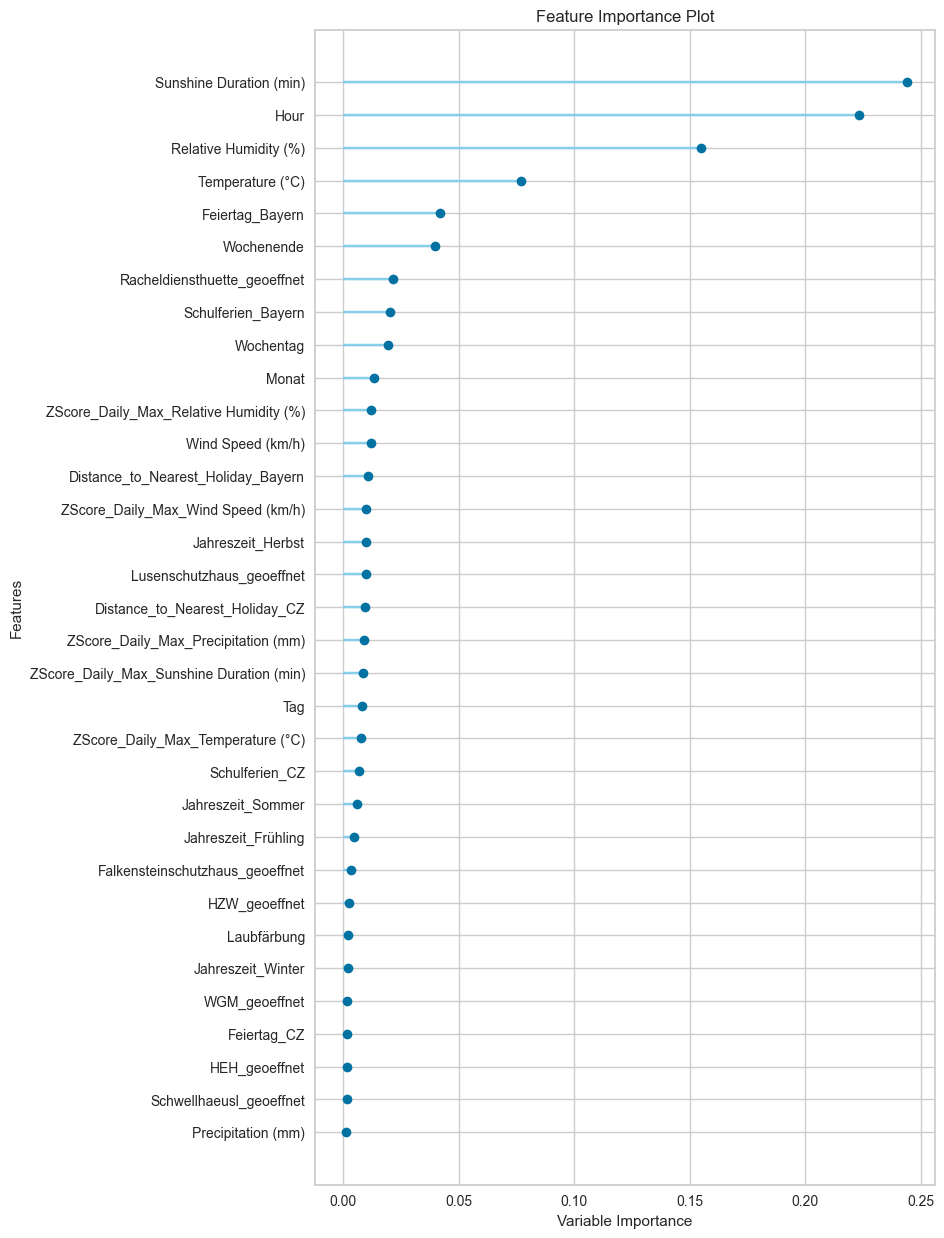

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'sum_IN_abs':


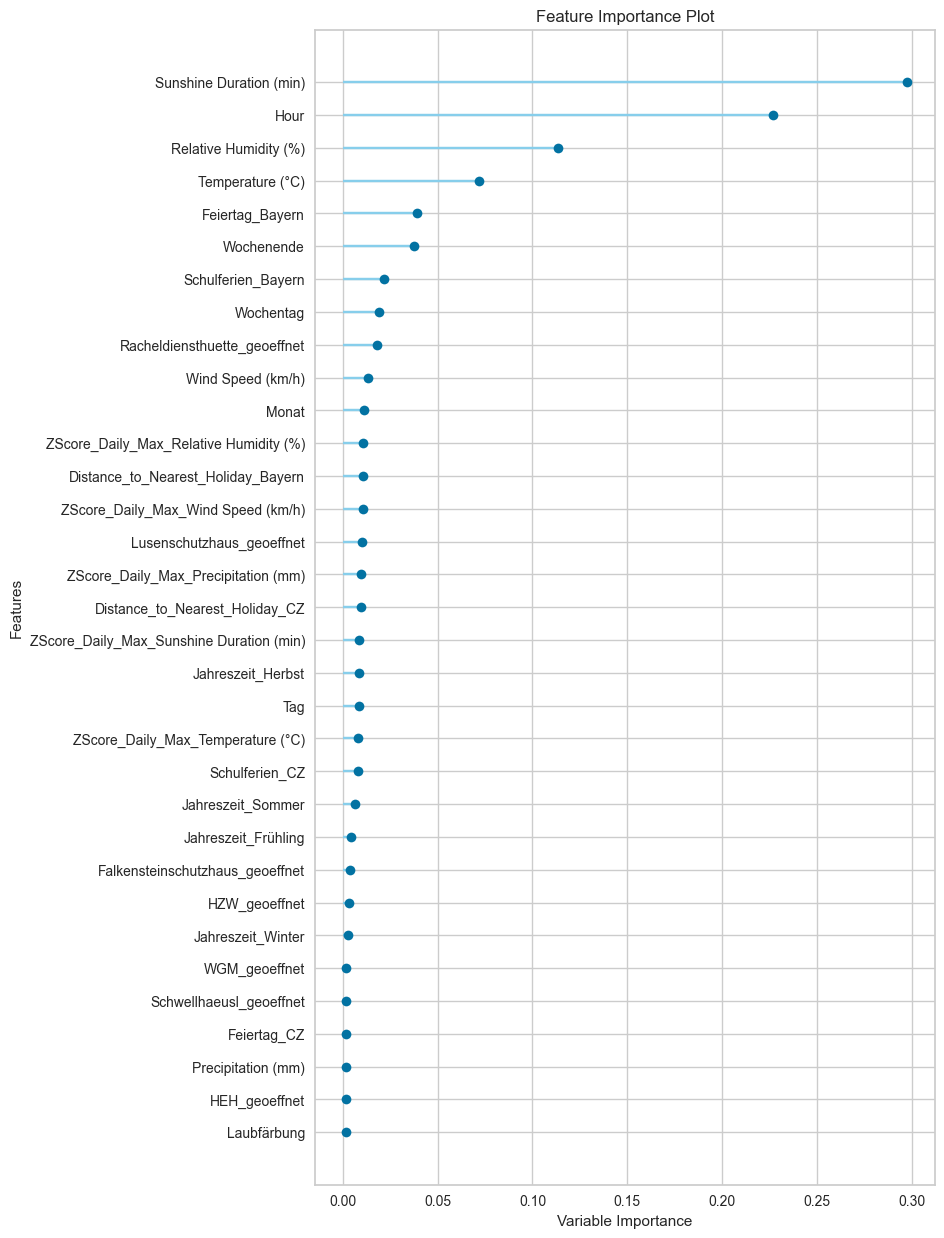

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'sum_OUT_abs':


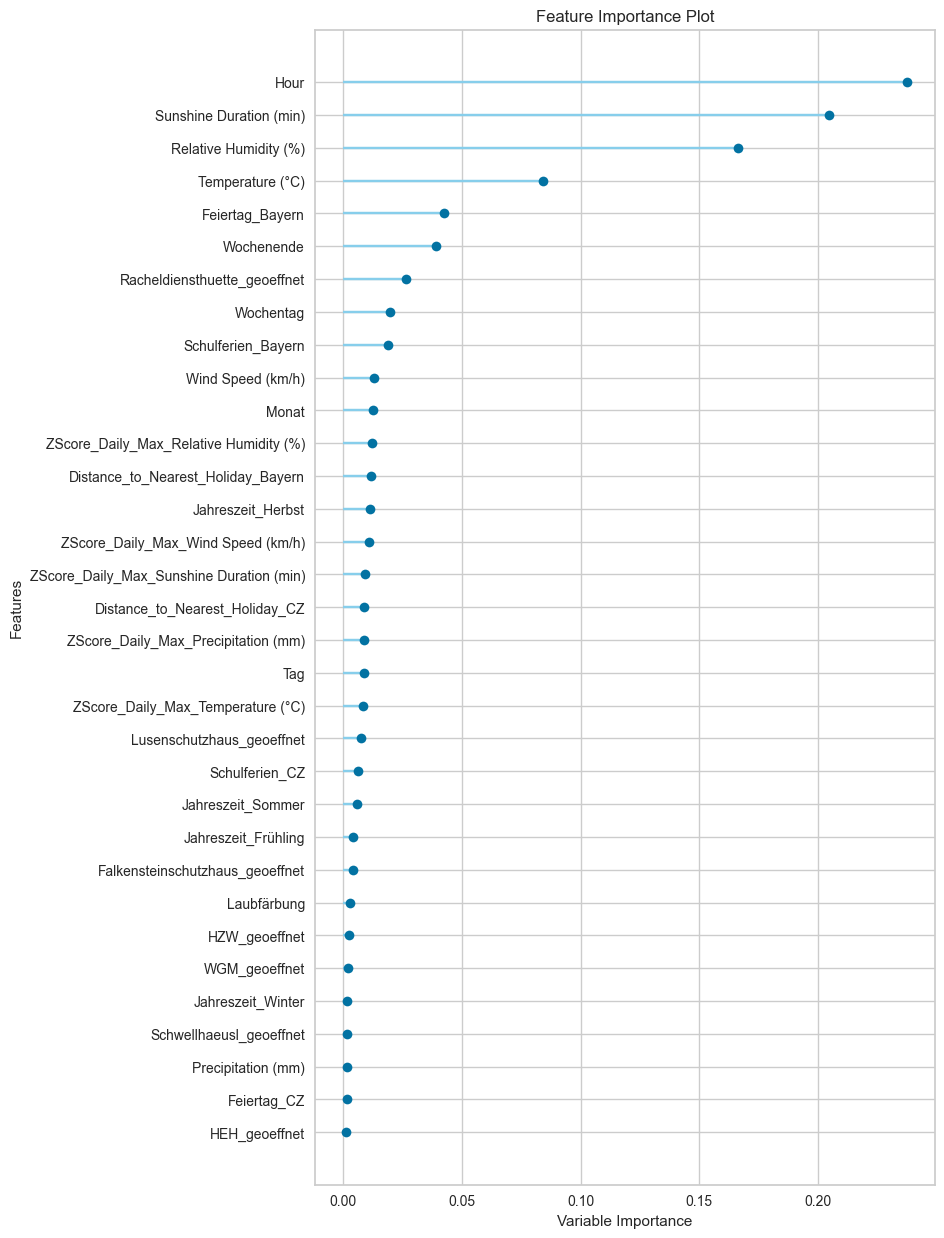

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Lusen-Mauth-Finsterau IN':


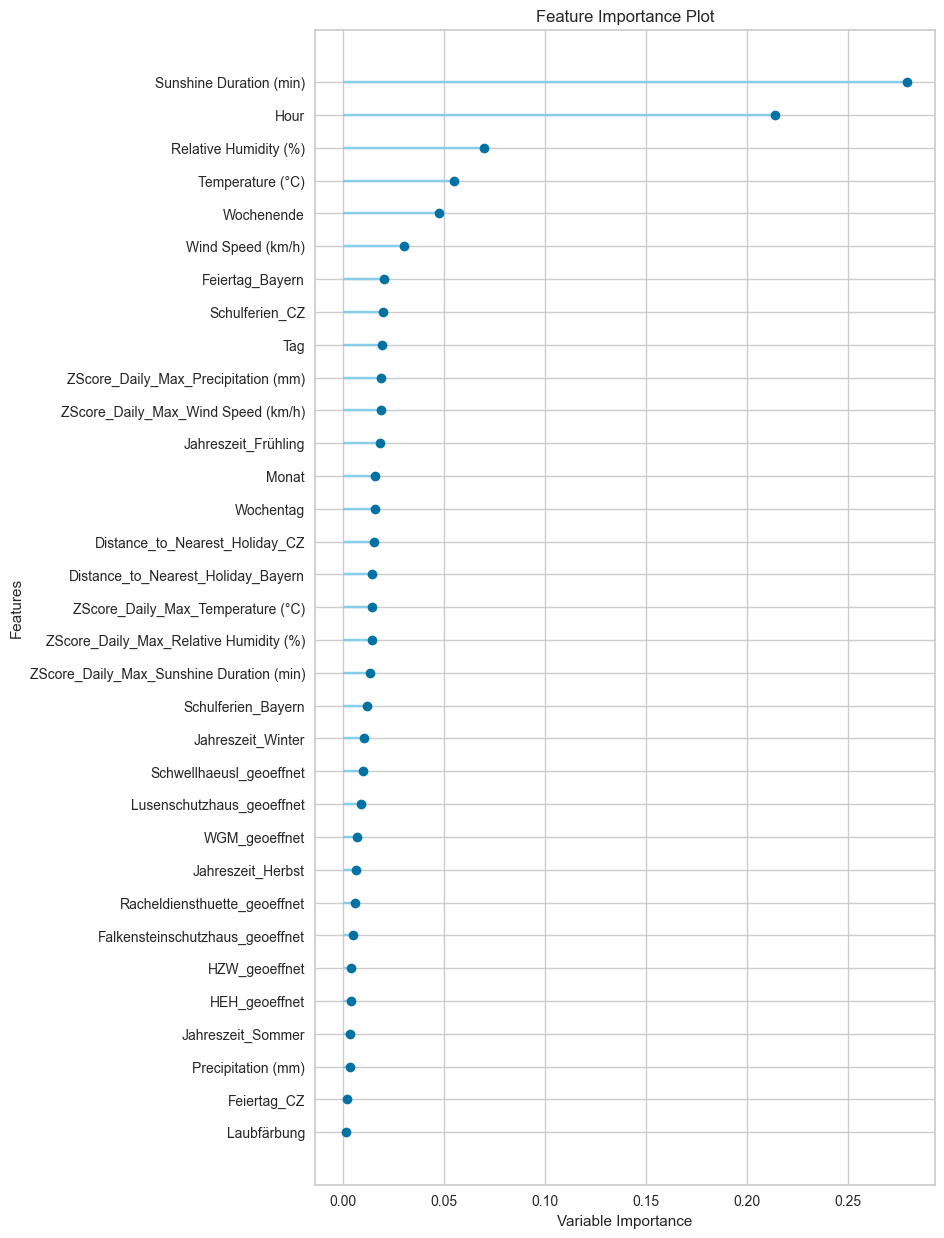

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Lusen-Mauth-Finsterau OUT':


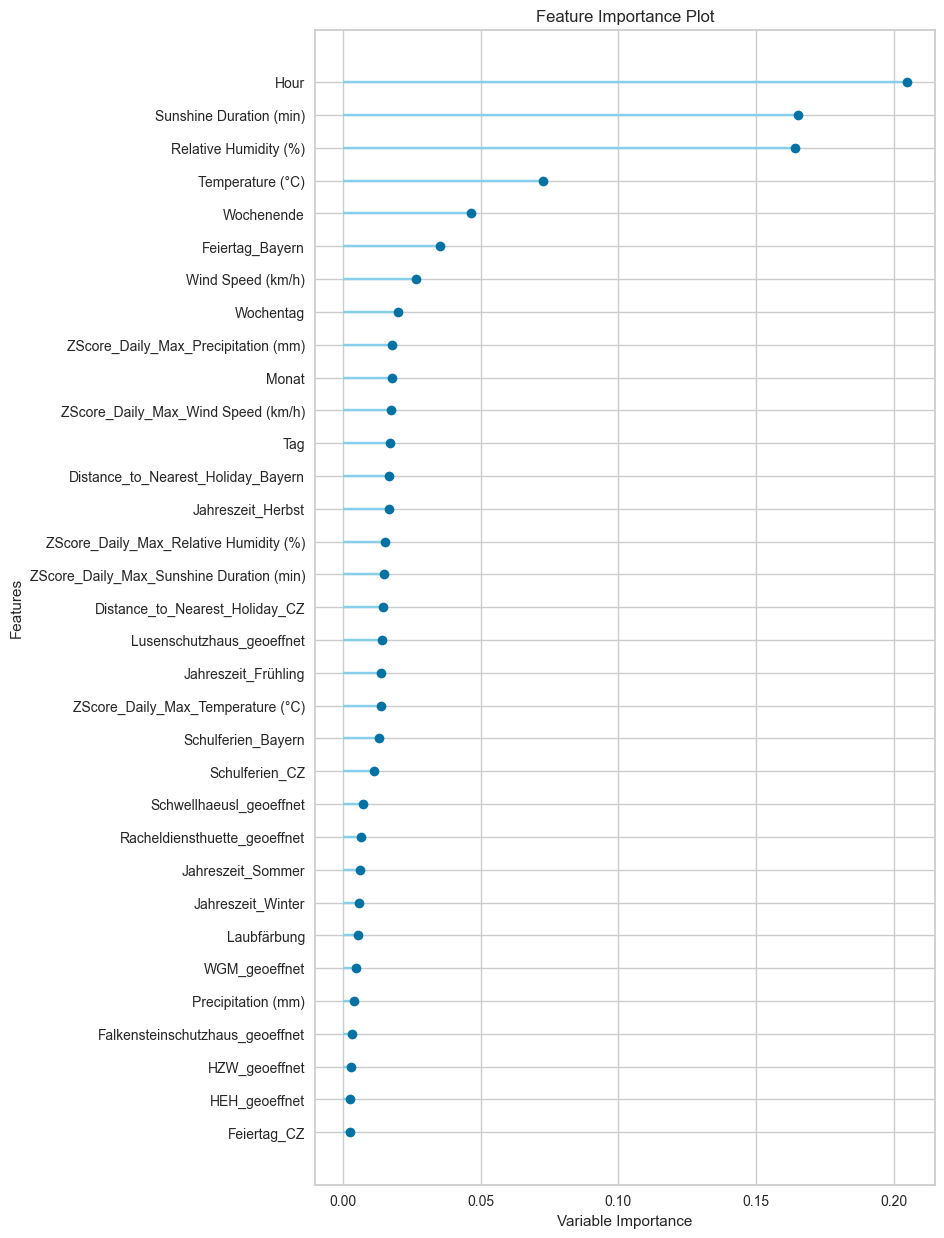

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Nationalparkzentrum Lusen IN':


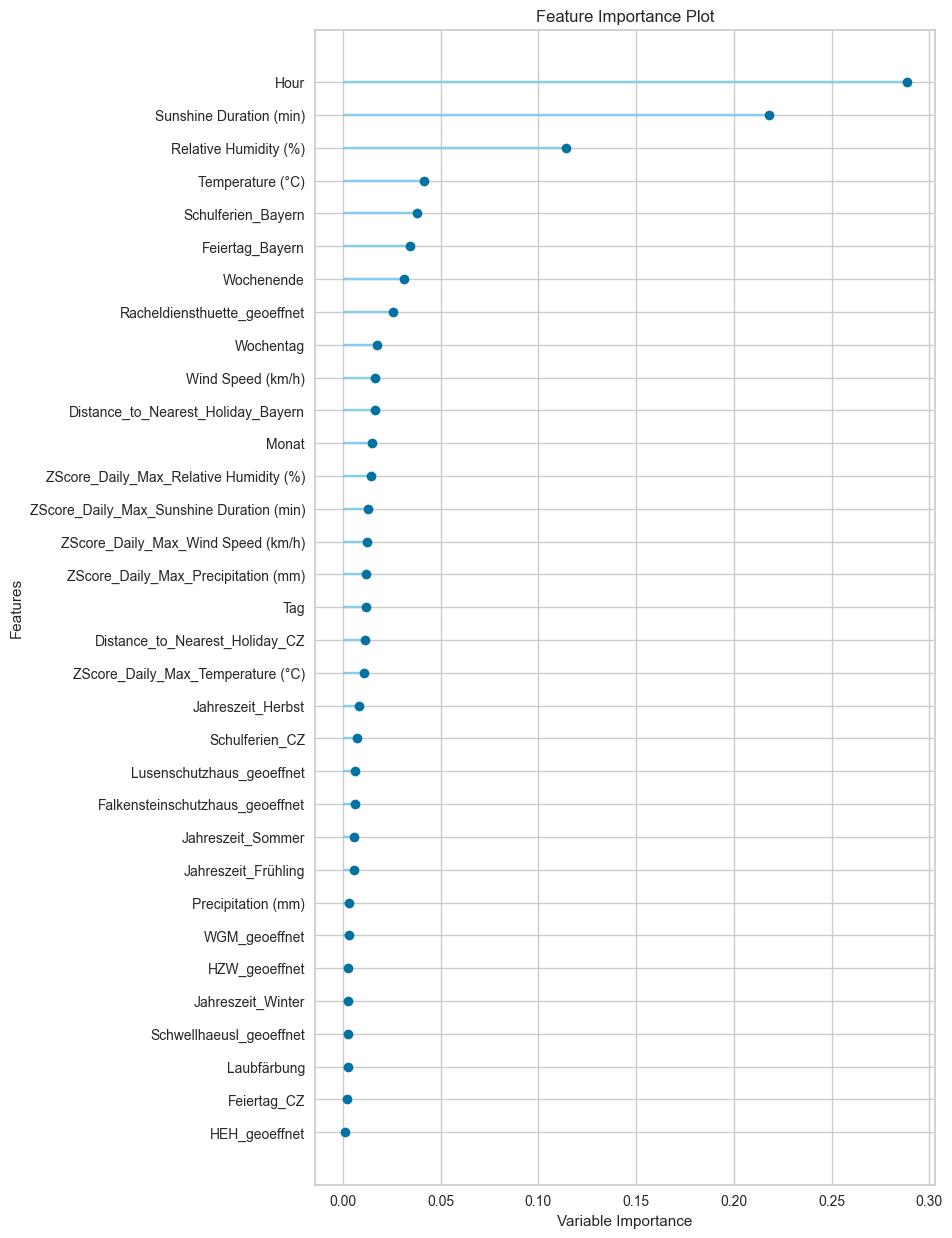

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Nationalparkzentrum Lusen OUT':


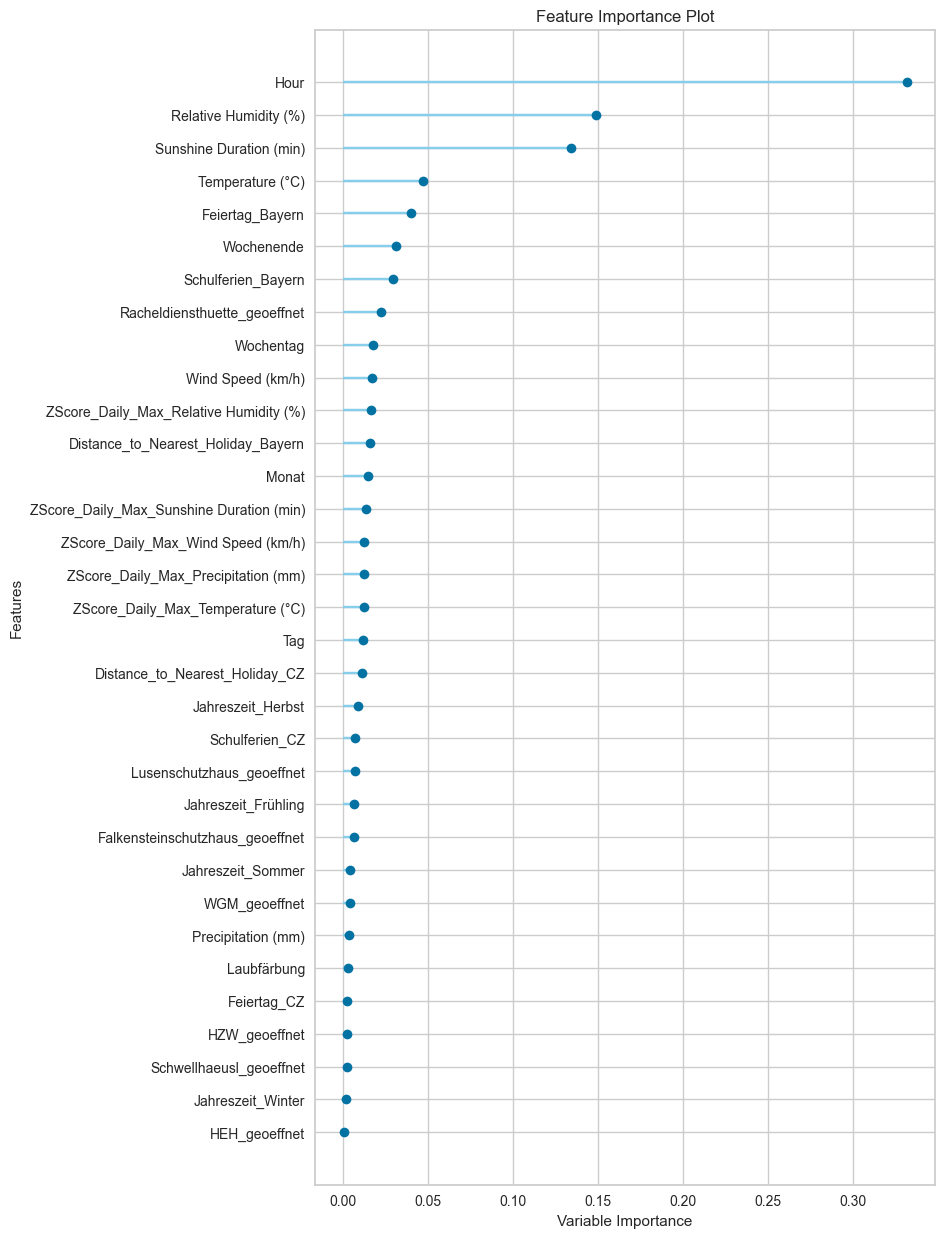

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Rachel-Spiegelau IN':


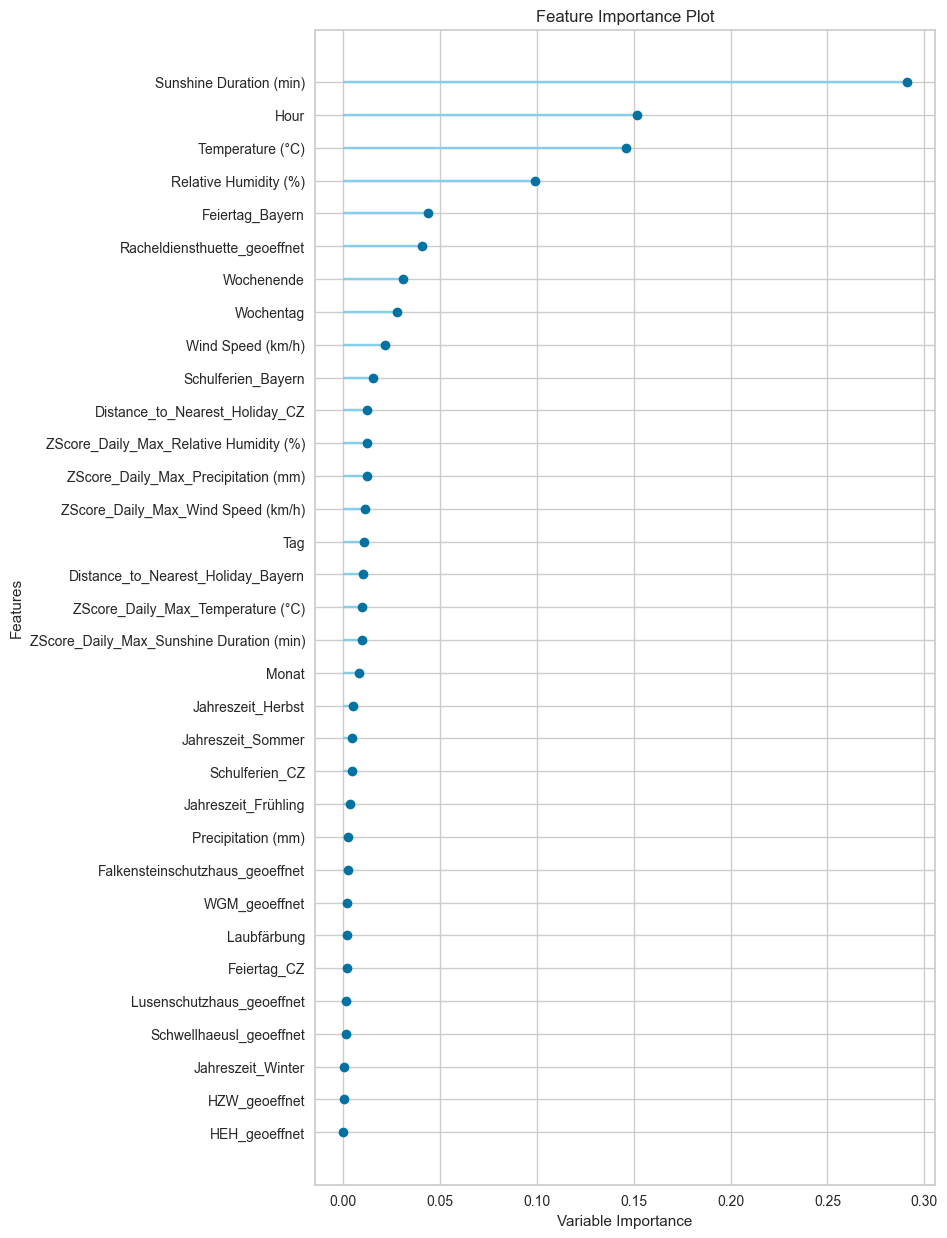

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Rachel-Spiegelau OUT':


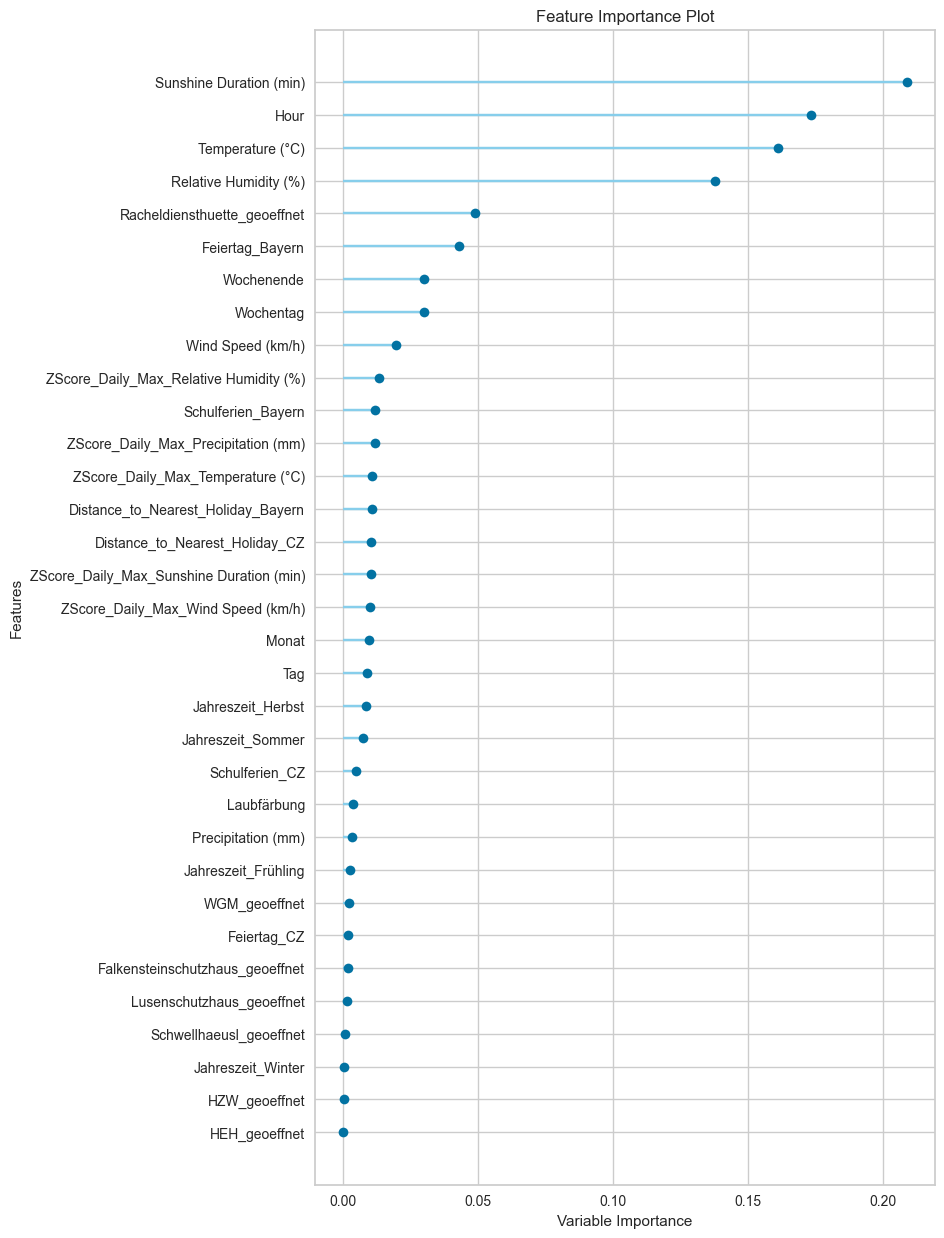

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Falkenstein-Schwellhäusl IN':


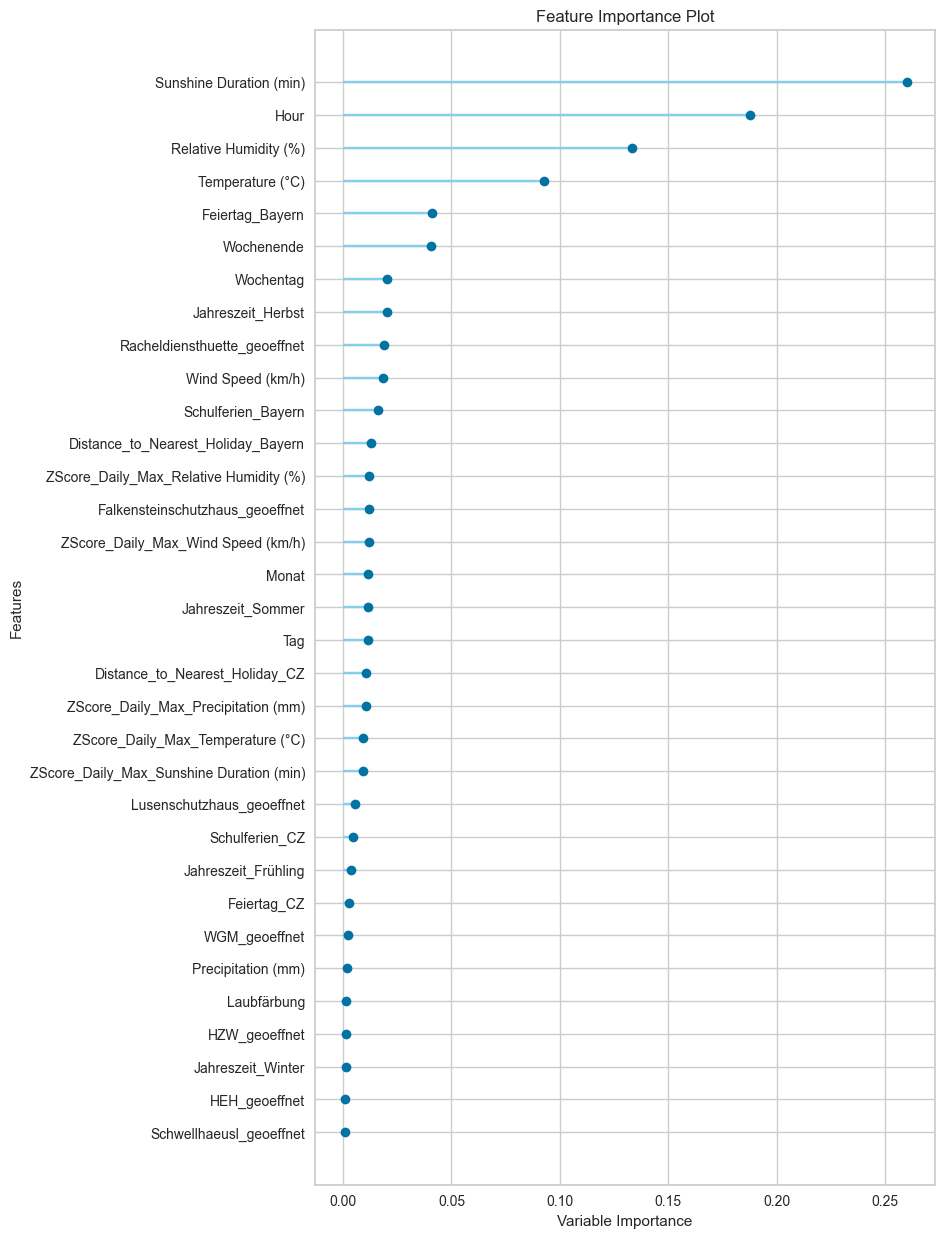

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Falkenstein-Schwellhäusl OUT':


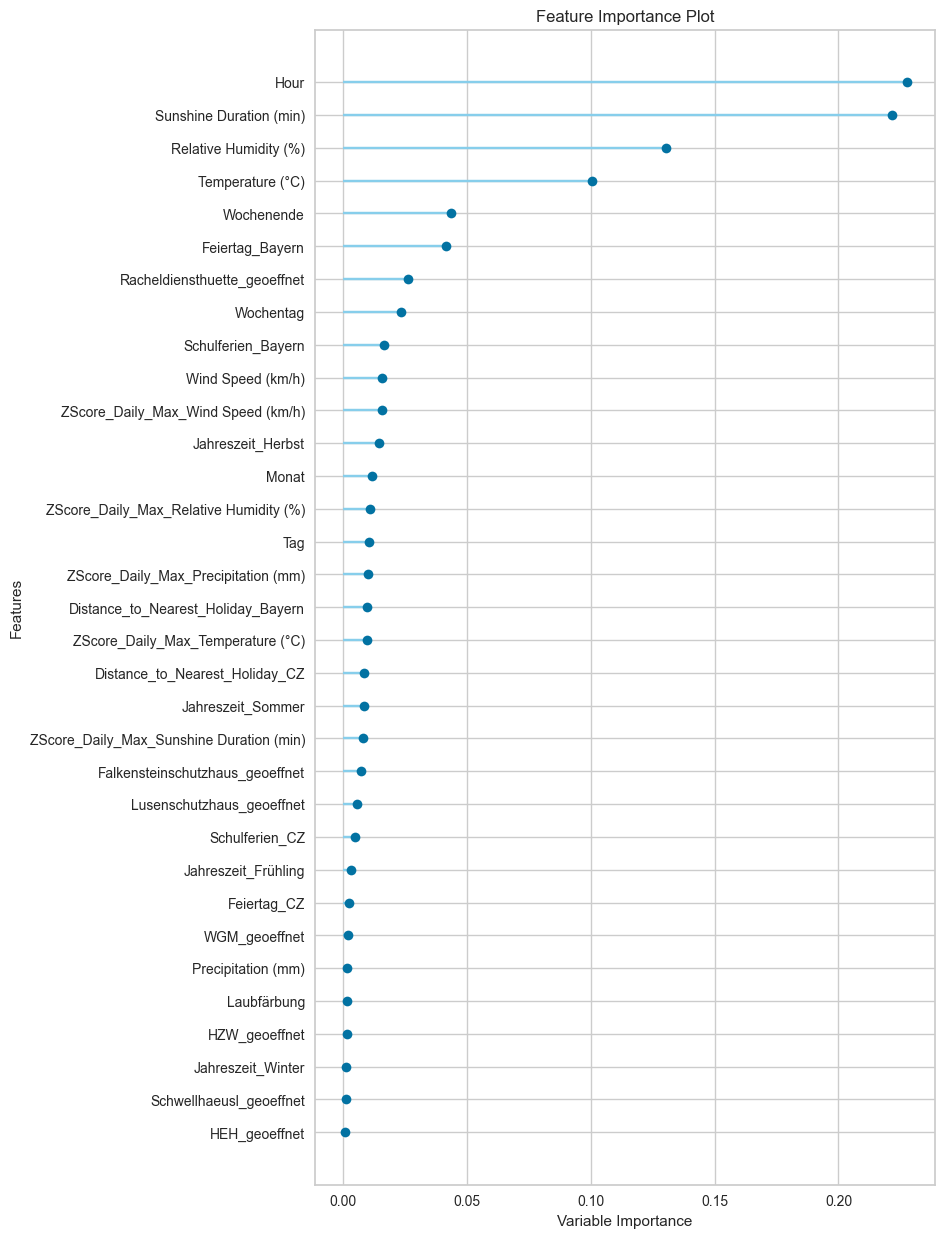

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Scheuereck-Schachten-Trinkwassertalsperre IN':


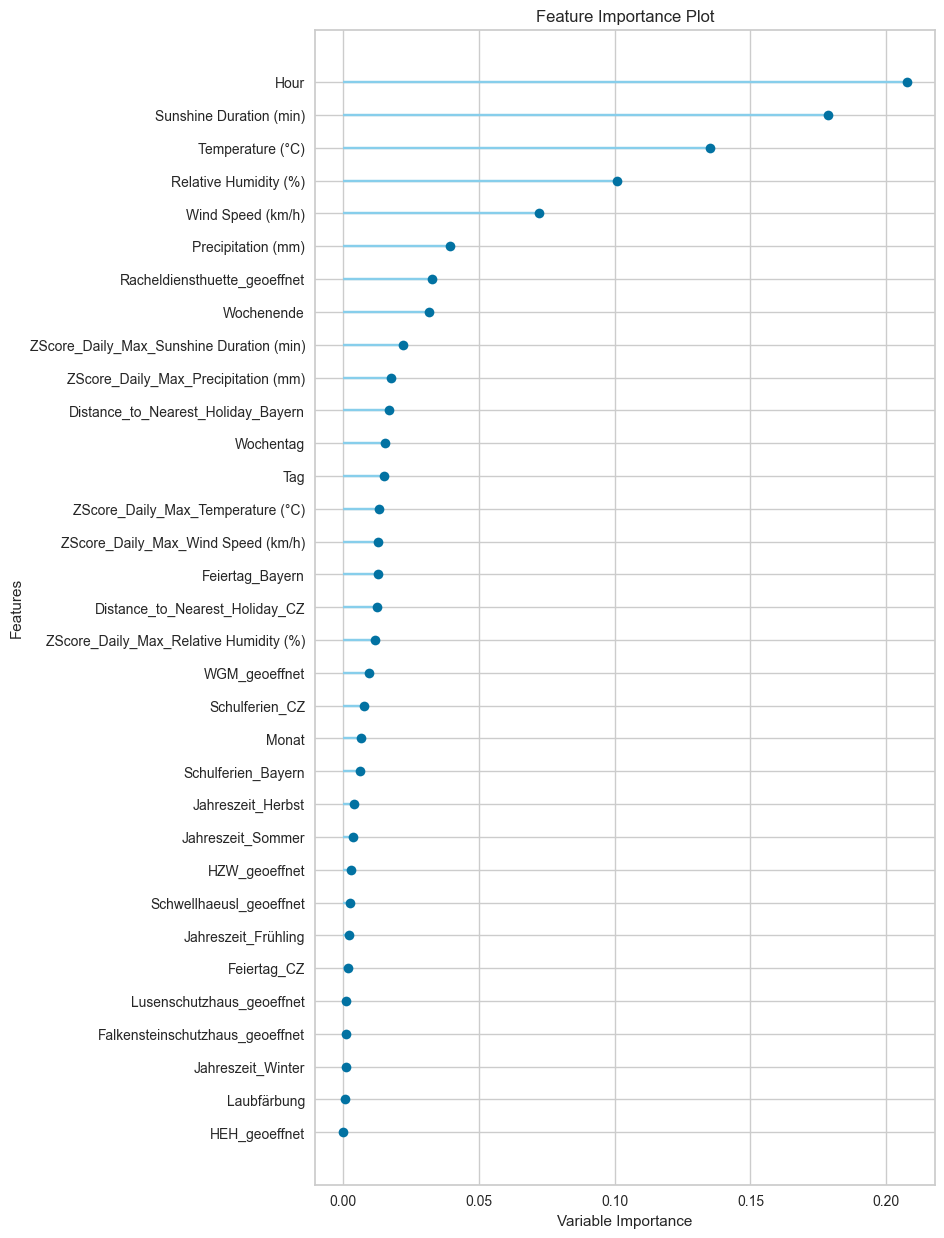

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Scheuereck-Schachten-Trinkwassertalsperre OUT':


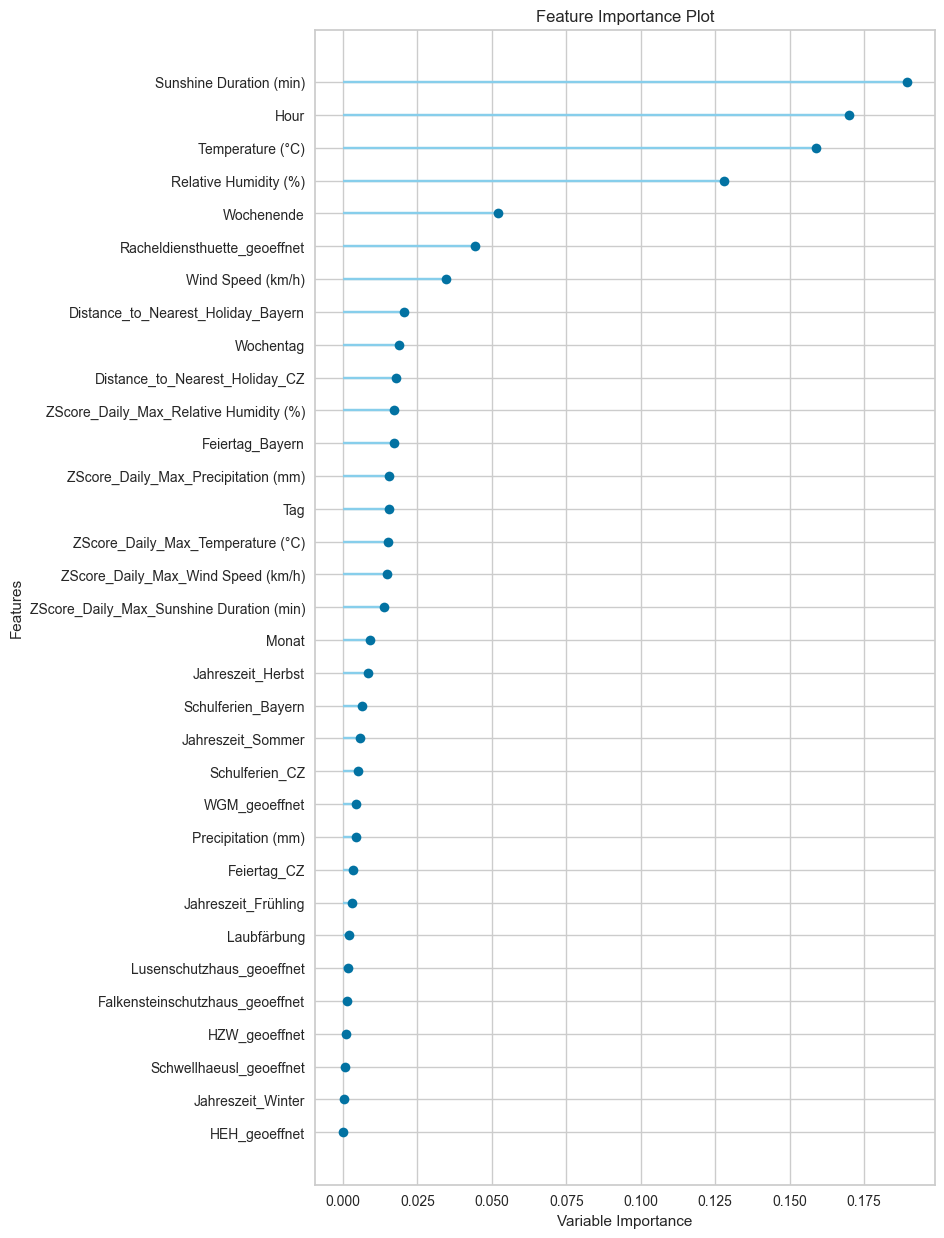

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Nationalparkzentrum Falkenstein IN':


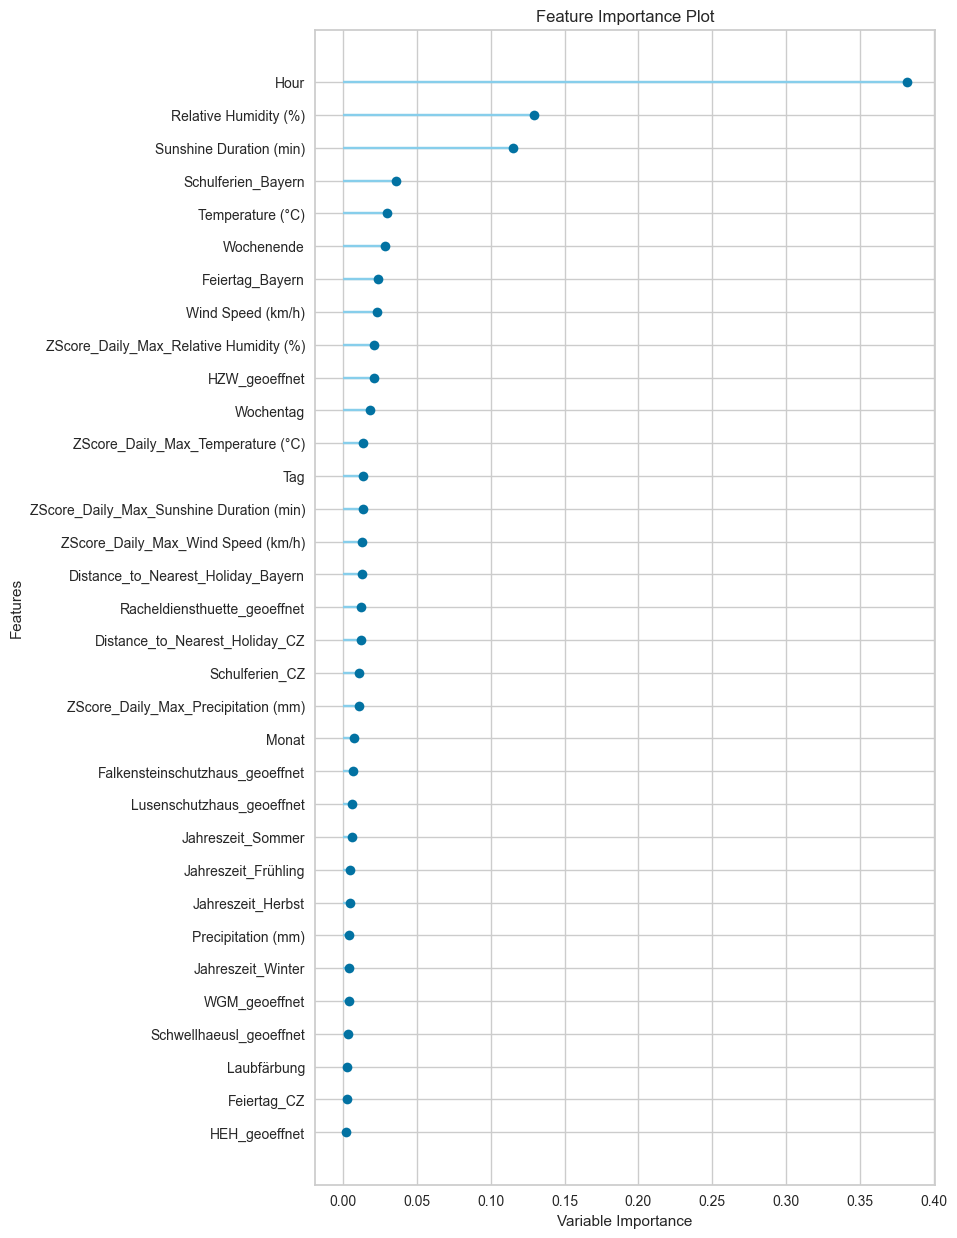

Transformation Pipeline and Model Successfully Loaded
Feature importance for Extra Trees model on target 'Nationalparkzentrum Falkenstein OUT':


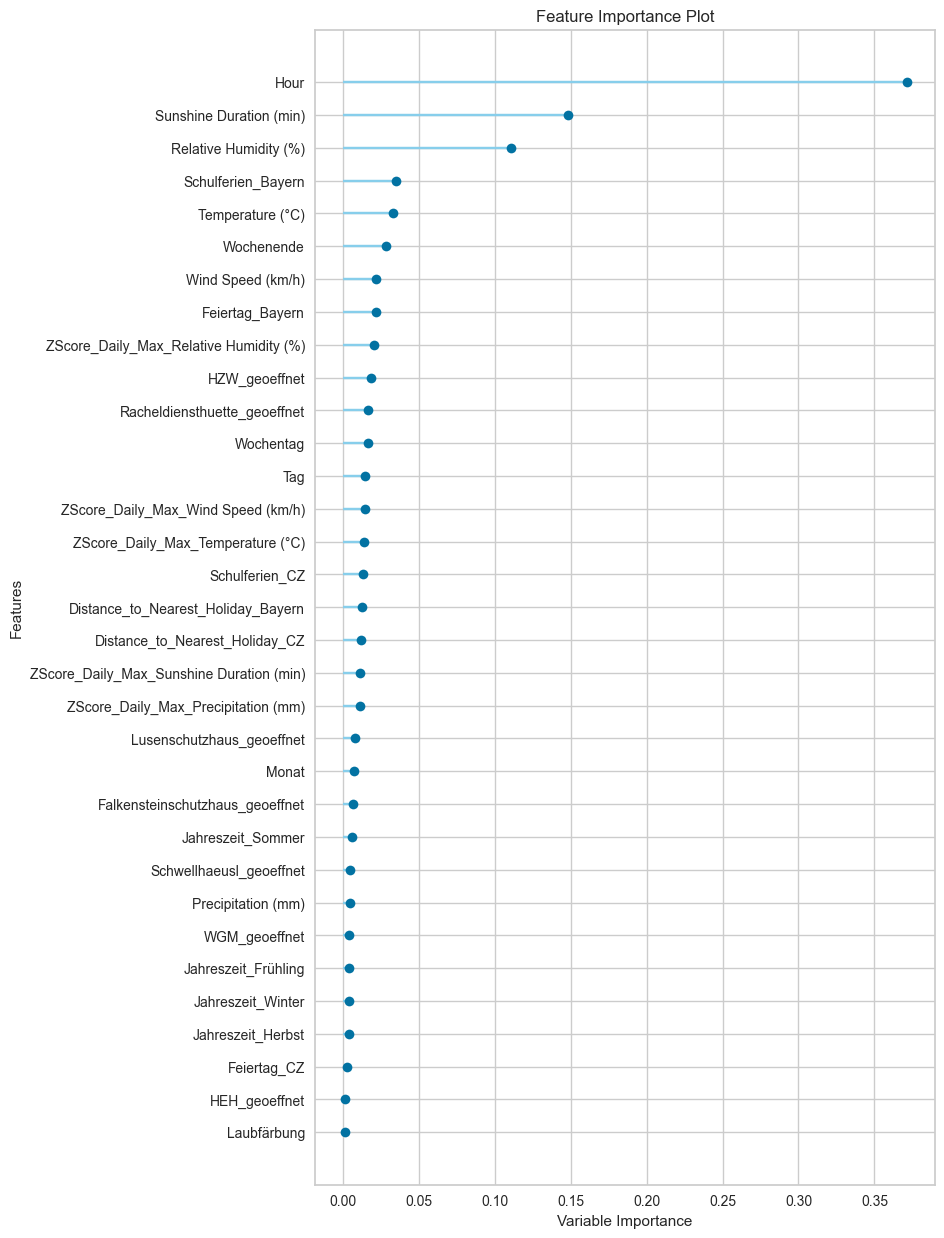

In [22]:
# Define the path to load models
save_path = r"C:\Users\garov\OneDrive\Documents\GitHub\bavarian-forest-visitor-monitoring-dssgx-24"

# Define target variable lists
target_vars_et = ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs', 'Lusen-Mauth-Finsterau IN', 'Lusen-Mauth-Finsterau OUT', 
               'Nationalparkzentrum Lusen IN', 'Nationalparkzentrum Lusen OUT', 'Rachel-Spiegelau IN', 'Rachel-Spiegelau OUT', 
               'Falkenstein-Schwellhäusl IN', 'Falkenstein-Schwellhäusl OUT', 
               'Scheuereck-Schachten-Trinkwassertalsperre IN', 'Scheuereck-Schachten-Trinkwassertalsperre OUT', 
               'Nationalparkzentrum Falkenstein IN', 'Nationalparkzentrum Falkenstein OUT']


# Plot feature importance for Extra Trees models
for target in target_vars_et:
    model_filename = f'extra_trees_{target}'
    full_model_path = os.path.join(save_path, model_filename)
    
    try:
        # Load the saved model
        loaded_model = load_model(full_model_path)
        
        # Plot feature importance
        print(f"Feature importance for Extra Trees model on target '{target}':")
        plot_model(loaded_model, plot='feature_all')
    
    except FileNotFoundError as e:
        print(f"File not found: {e}")
              

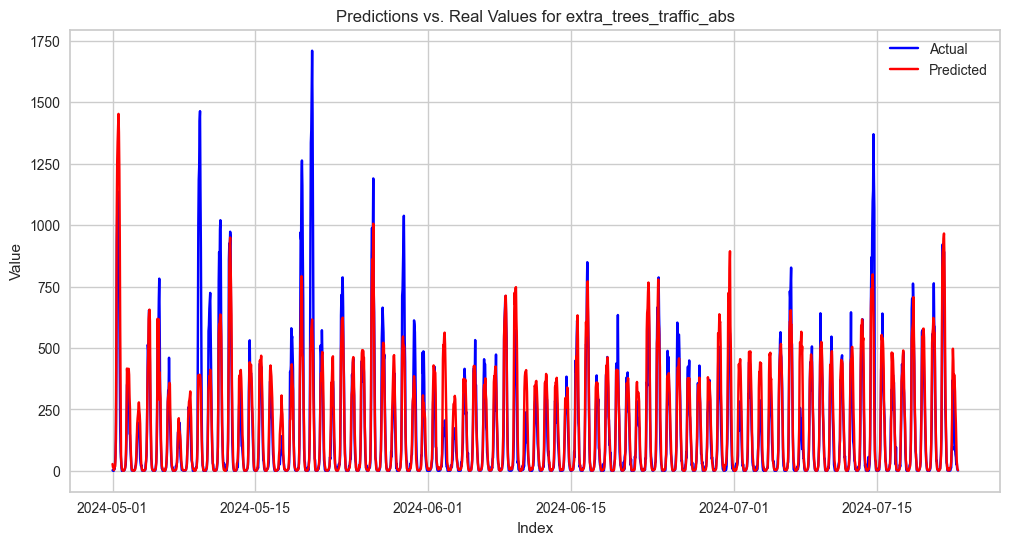

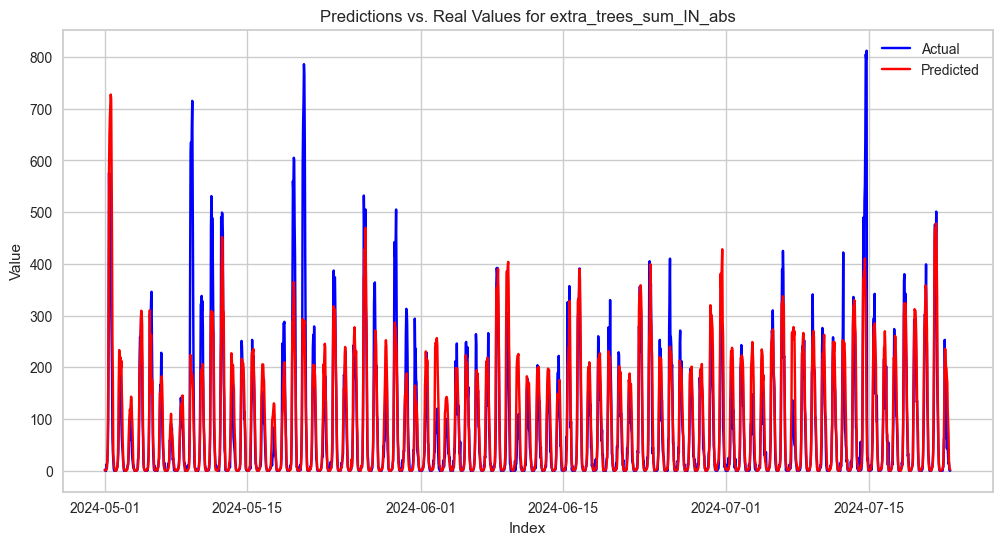

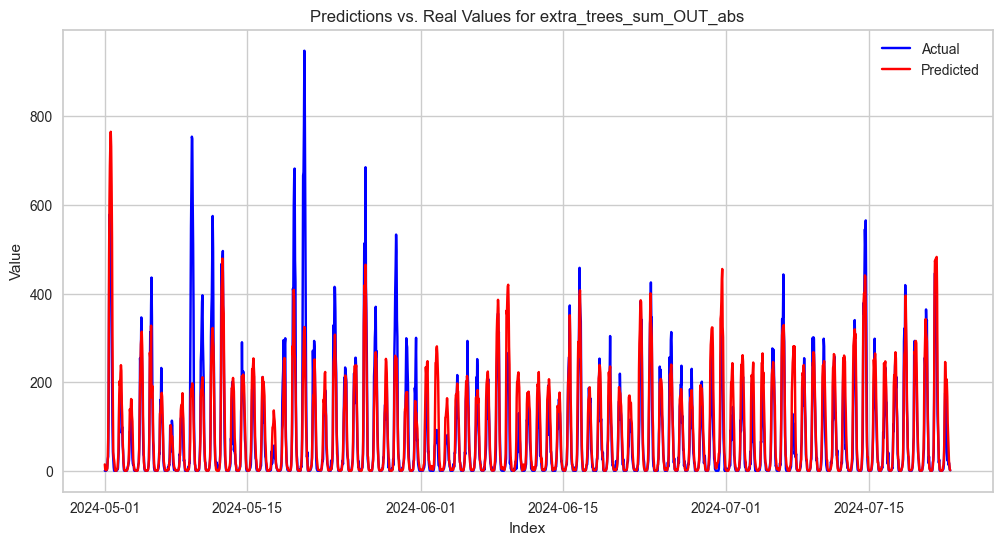

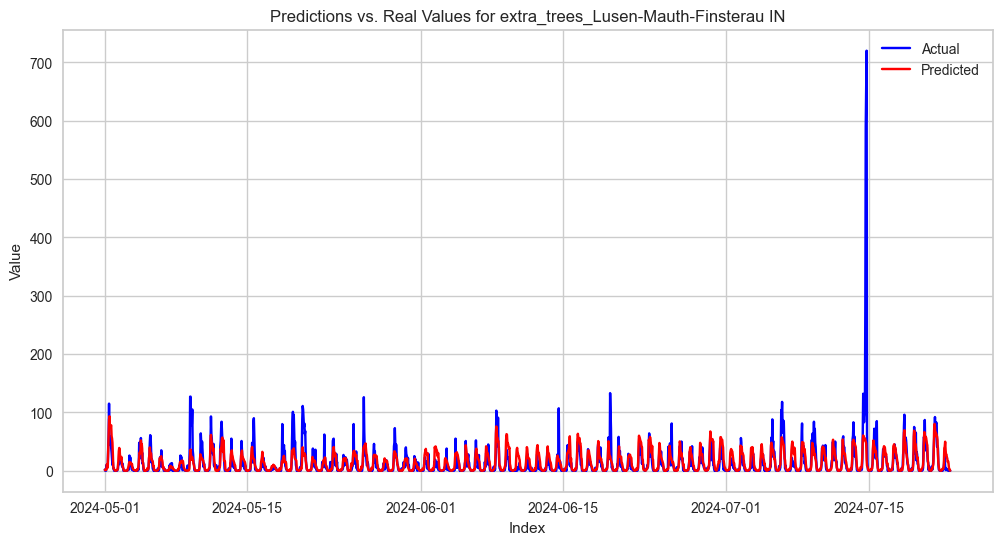

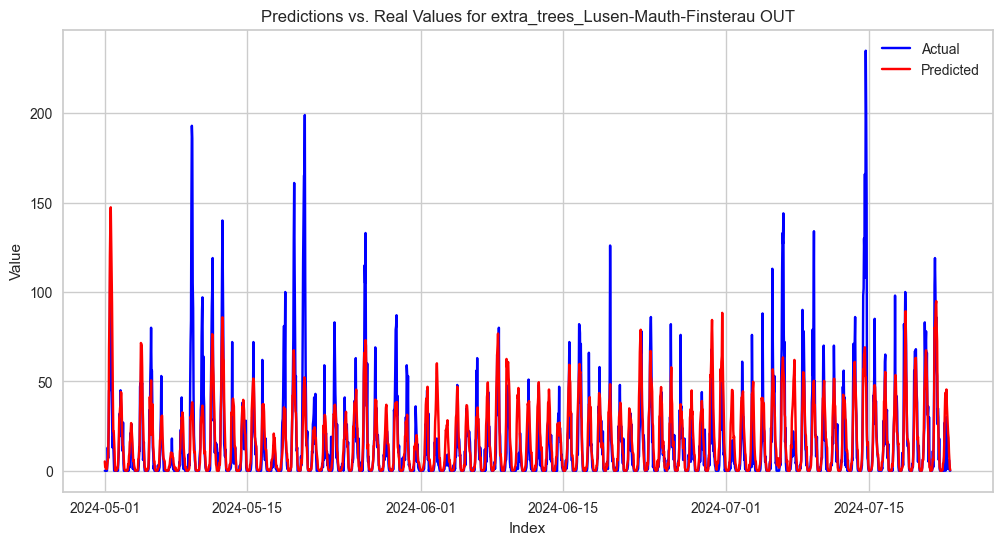

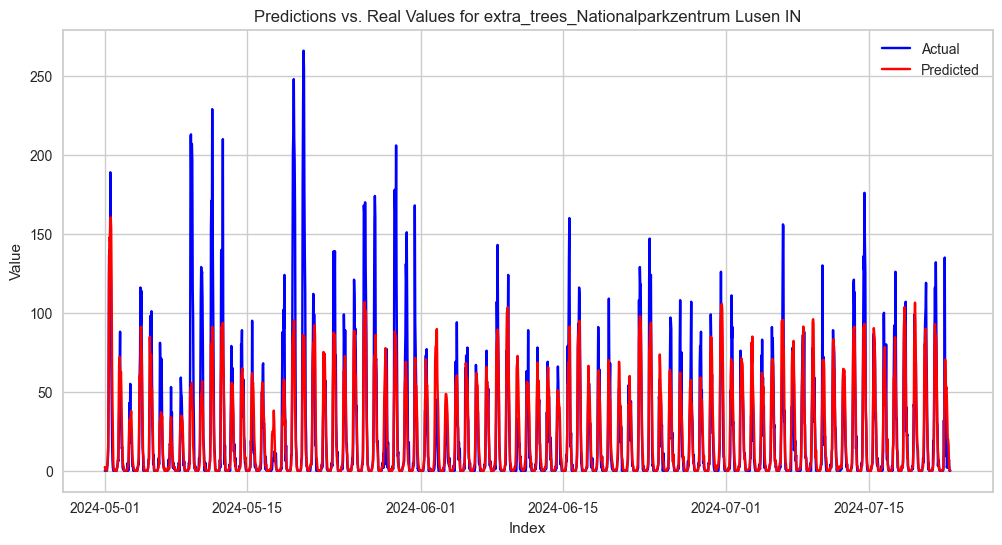

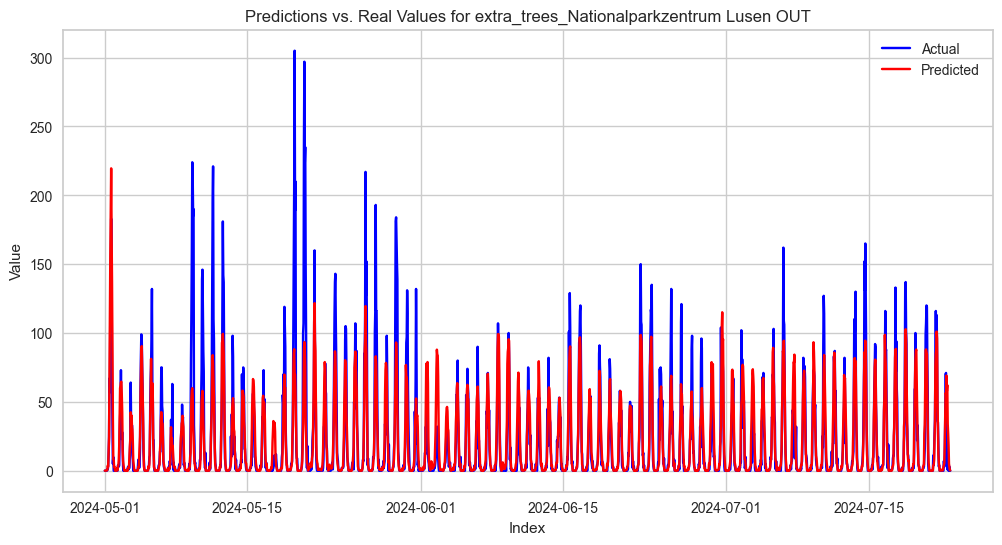

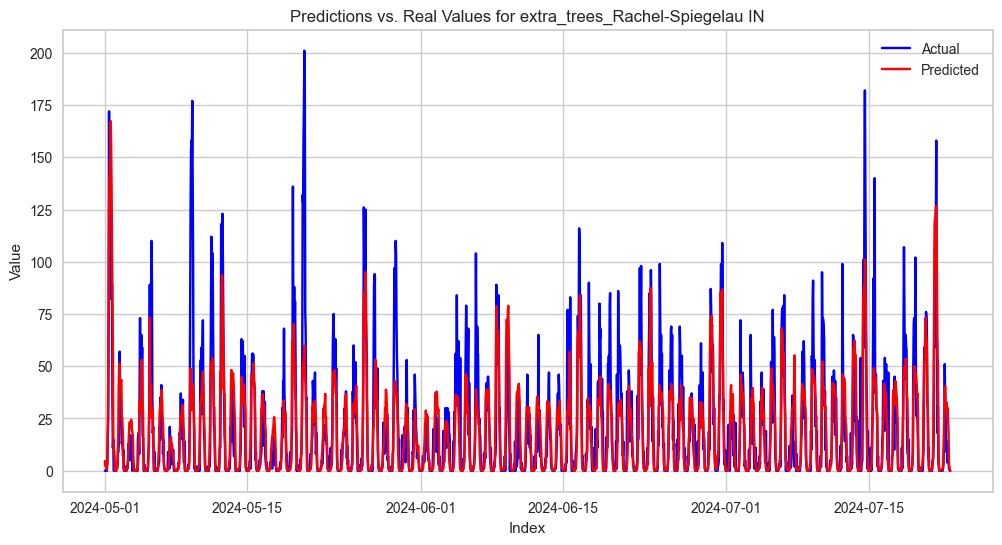

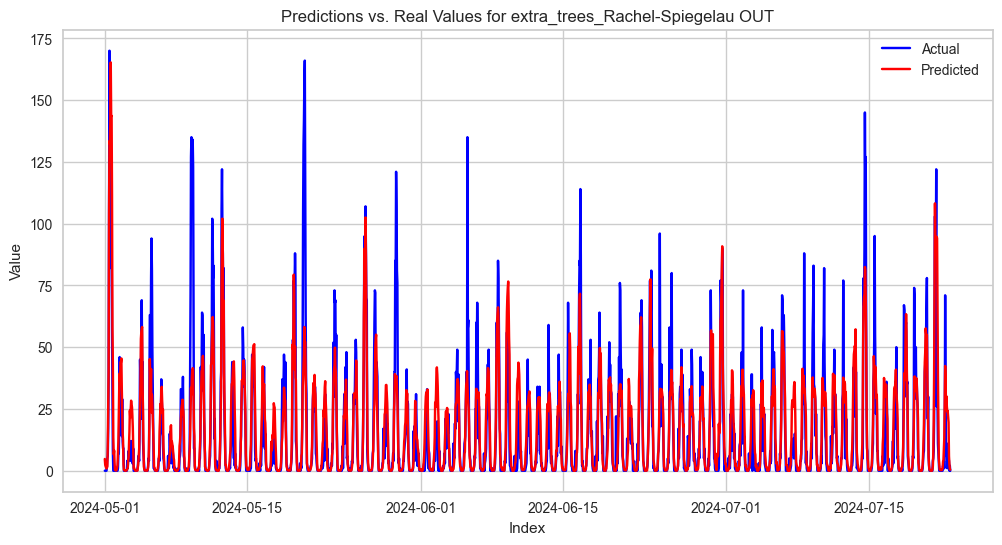

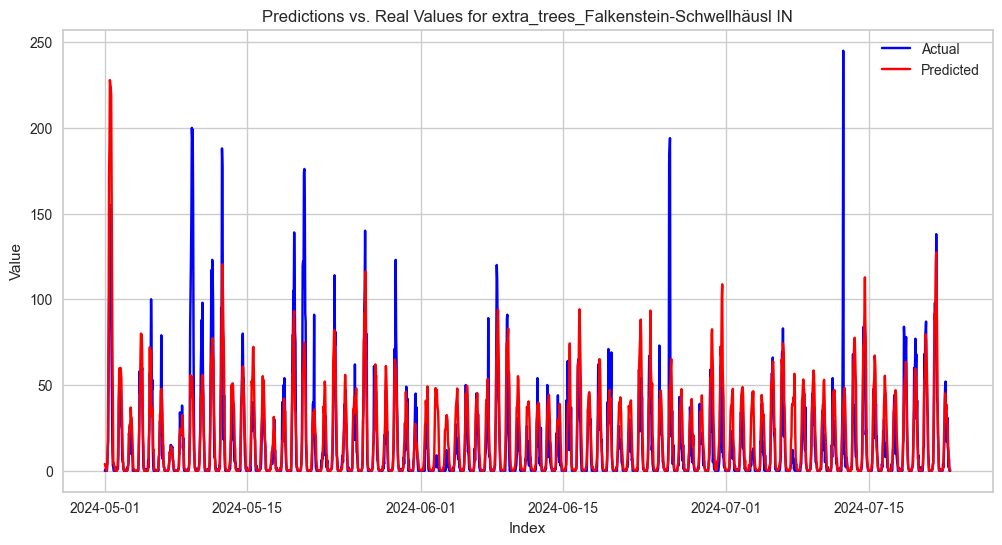

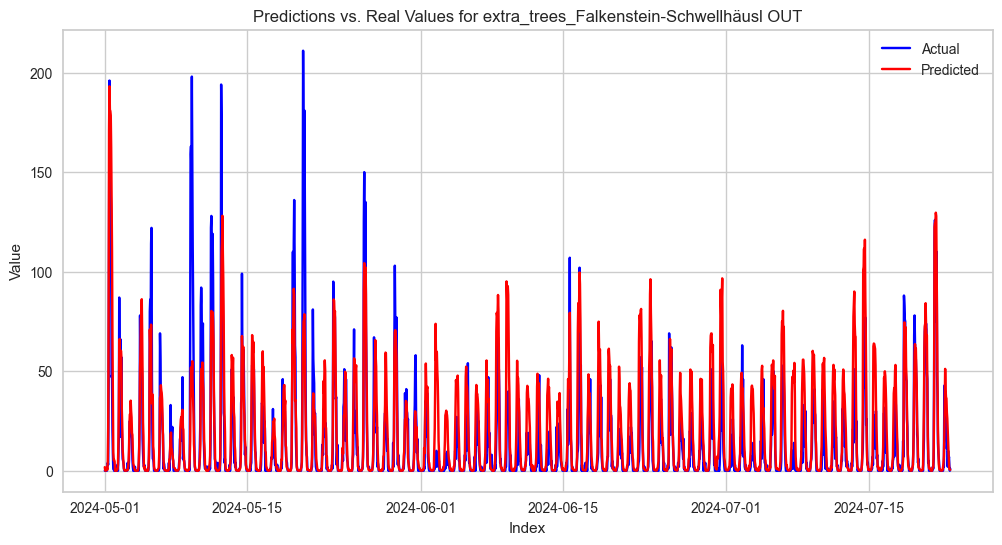

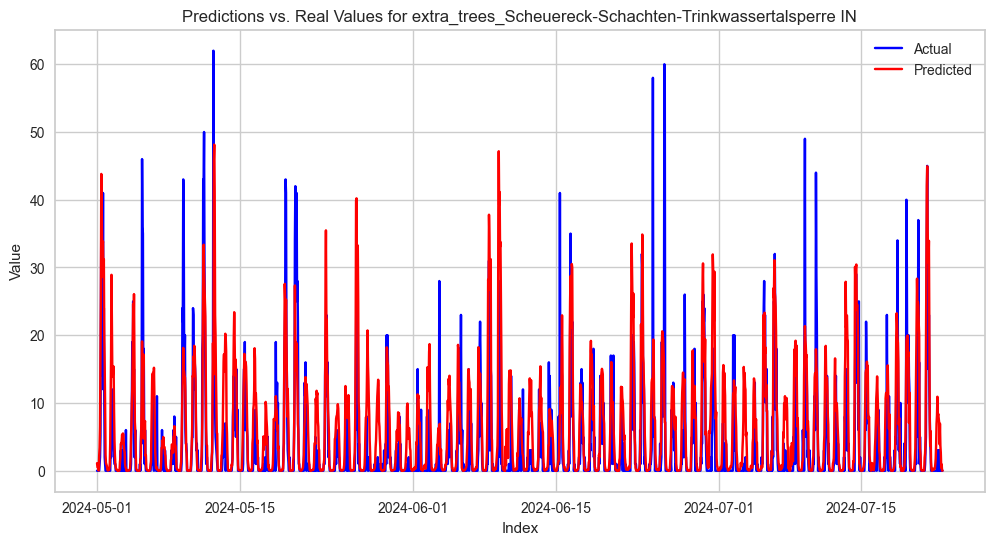

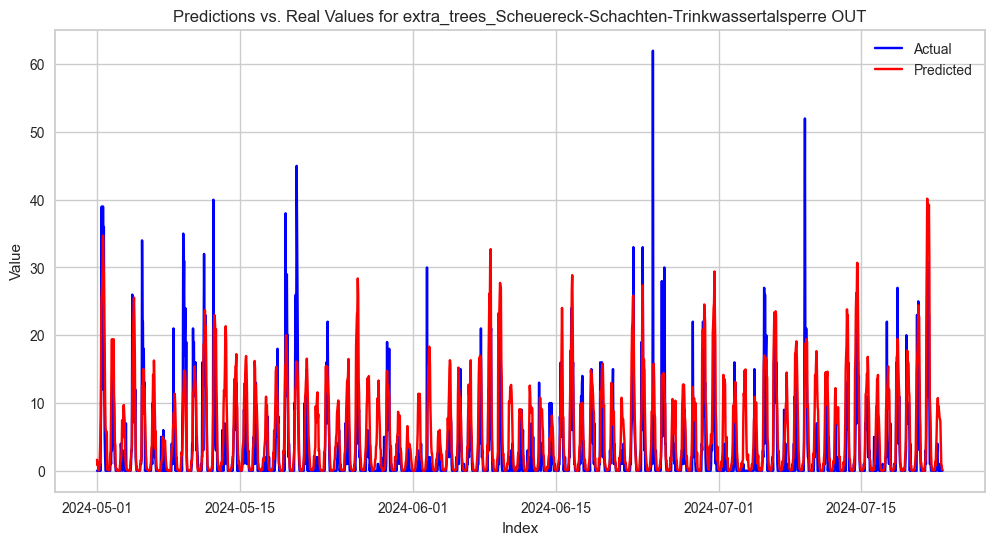

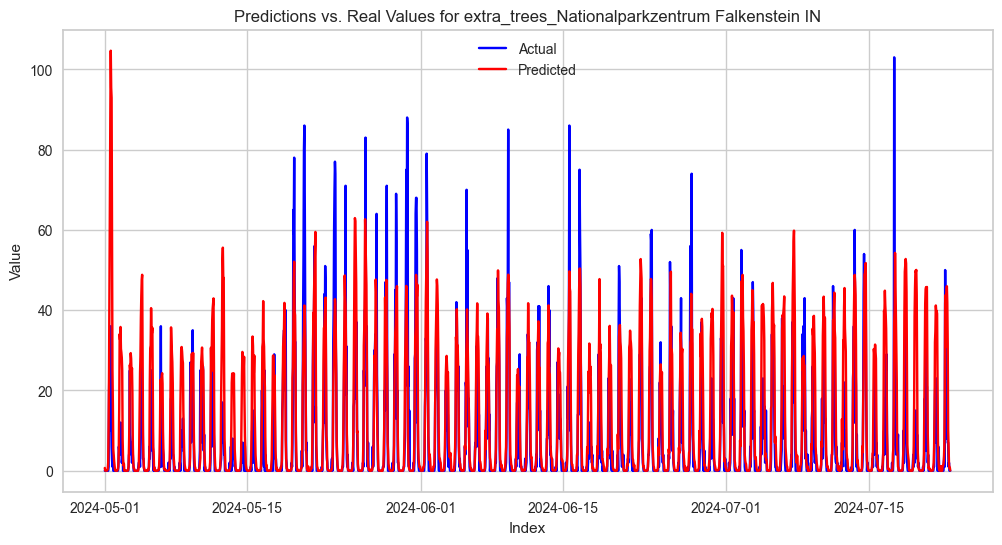

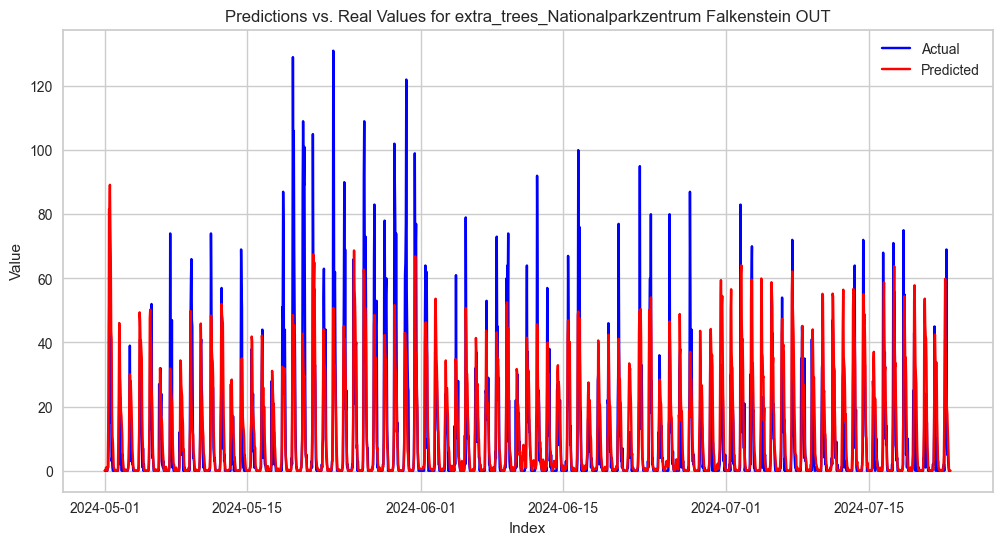

In [23]:
# Visualize predictions for Extra Trees models
for key, predictions_et in predictions_dict_et.items():
    target = key.split('_', 2)[-1]  # This assumes the format 'extra_trees_<target>'
    
    if "prediction_label" in predictions_et.columns and target in predictions_et.columns:
        predictions_vs_real_et = predictions_et[[target, "prediction_label"]].sort_index(ascending=True)
        
        # Create a line plot using Matplotlib
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_vs_real_et.index, predictions_vs_real_et[target], label='Actual', color='blue')
        plt.plot(predictions_vs_real_et.index, predictions_vs_real_et["prediction_label"], label='Predicted', color='red')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title(f"Predictions vs. Real Values for {key}")
        plt.legend()
        plt.show()
    else:
        print(f"Columns '{target}' and 'prediction_label' not found in predictions for {key}")

In [24]:
for key, predictions_et in predictions_dict_et.items():
    target = key.split('_', 2)[-1]  # This assumes the format 'extra_trees_<target>'
    
    if "prediction_label" in predictions_et.columns and target in predictions_et.columns:
        # Resample predictions and actual values on a daily basis
        daily_prediction_comparison = predictions_et[[target, "prediction_label"]].resample("1d").sum()

        # Calculate the mean absolute error (MAE)
        daily_prediction_comparison["mae"] = abs(daily_prediction_comparison[target] - daily_prediction_comparison["prediction_label"])
        print(f"The MAE on a daily basis for {target} is {daily_prediction_comparison['mae'].mean()}.")

        # Plot the actual vs predicted values using Plotly Express
        fig = px.line(daily_prediction_comparison, y=[target, "prediction_label"],
                      labels={"value": "Value", "variable": "Legend"},
                      title=f"Daily Predictions vs Actuals for {target}")
        fig.show()

    else:
        print(f"Columns '{target}' and 'prediction_label' not found in predictions for {key}")


The MAE on a daily basis for traffic_abs is 1043.3712048192772.


The MAE on a daily basis for sum_IN_abs is 545.992530120482.


The MAE on a daily basis for sum_OUT_abs is 571.4992771084337.


The MAE on a daily basis for Lusen-Mauth-Finsterau IN is 136.73867469879517.


The MAE on a daily basis for Lusen-Mauth-Finsterau OUT is 141.55795180722896.


The MAE on a daily basis for Nationalparkzentrum Lusen IN is 156.02361445783134.


The MAE on a daily basis for Nationalparkzentrum Lusen OUT is 153.47915662650604.


The MAE on a daily basis for Rachel-Spiegelau IN is 132.93855421686746.


The MAE on a daily basis for Rachel-Spiegelau OUT is 100.72951807228917.


The MAE on a daily basis for Falkenstein-Schwellhäusl IN is 165.5532530120482.


The MAE on a daily basis for Falkenstein-Schwellhäusl OUT is 183.44277108433732.


The MAE on a daily basis for Scheuereck-Schachten-Trinkwassertalsperre IN is 61.24192771084337.


The MAE on a daily basis for Scheuereck-Schachten-Trinkwassertalsperre OUT is 61.66915662650602.


The MAE on a daily basis for Nationalparkzentrum Falkenstein IN is 110.69192771084337.


The MAE on a daily basis for Nationalparkzentrum Falkenstein OUT is 96.73289156626505.


In [25]:
for key, predictions_et in predictions_dict_et.items():
    target = key.split('_', 2)[-1]  # This assumes the format 'extra_trees_<target>'
    
    if "prediction_label" in predictions_et.columns and target in predictions_et.columns:
        # Resample predictions and actual values on a daily basis
        daily_prediction_comparison = predictions_et[[target, "prediction_label"]].resample("1d").sum()

        # Calculate the mean absolute error (MAE) on a daily basis
        daily_prediction_comparison["mae"] = abs(daily_prediction_comparison[target] - daily_prediction_comparison["prediction_label"])

        # Print the average number of people visiting the park (or any other target)
        print(f"On average, {daily_prediction_comparison[target].mean()} people are visiting the park daily for {target}.")

        # Create a box plot of the MAE using Plotly Express
        fig_box = px.box(daily_prediction_comparison, y="mae", title=f"MAE Distribution for {target}")
        fig_box.show()

        # Identify the top 50 days with the highest error
        high_error_dates = daily_prediction_comparison["mae"].sort_values(ascending=False).head(50)
        print(high_error_dates)

        # Retrieve and print training data columns using PyCaret's get_config function
        X_train = get_config('X_train')
        X_train_columns = X_train.columns.to_list()
        print(f"Training columns for {target}: {X_train_columns}")

    else:
        print(f"Columns '{target}' and 'prediction_label' not found in predictions for {key}")



On average, 3946.2529296875 people are visiting the park daily for traffic_abs.


Time
2024-05-09    6618.83
2024-05-20    6251.44
2024-05-01    4063.96
2024-07-14    3379.61
2024-06-02    3174.95
2024-07-07    2978.12
2024-05-19    2924.08
2024-05-29    2427.08
2024-06-09    2387.99
2024-06-30    2130.03
2024-06-10    2066.34
2024-05-10    1756.01
2024-05-11    1678.31
2024-06-29    1664.58
2024-07-03    1648.93
2024-07-22    1617.93
2024-07-01    1514.04
2024-05-18    1288.04
2024-05-13    1251.19
2024-05-30    1229.35
2024-05-17    1217.52
2024-05-16    1147.95
2024-06-03    1134.37
2024-07-04    1132.29
2024-07-21    1132.21
2024-06-22    1103.34
2024-06-01    1079.15
2024-07-12    1071.75
2024-06-12    1049.09
2024-06-11    1040.96
2024-05-27     935.67
2024-06-25     934.54
2024-05-28     920.44
2024-06-21     903.84
2024-07-13     884.96
2024-05-02     863.36
2024-06-13     840.89
2024-05-15     807.23
2024-05-22     798.32
2024-07-02     784.95
2024-05-23     783.22
2024-05-03     771.11
2024-05-26     764.61
2024-05-05     647.63
2024-06-07     630.81
2024-

Time
2024-05-09    3291.34
2024-05-20    2997.53
2024-07-14    2559.27
2024-05-01    2224.71
2024-07-07    1581.54
2024-05-19    1528.53
2024-06-02    1428.22
2024-06-09    1347.43
2024-06-10    1135.91
2024-05-29    1089.91
2024-06-30    1005.38
2024-07-03     938.36
2024-05-11     769.20
2024-07-22     767.11
2024-05-10     763.01
2024-07-01     733.57
2024-05-13     724.80
2024-05-30     634.57
2024-05-17     630.31
2024-05-16     626.61
2024-06-29     622.95
2024-05-02     606.45
2024-07-13     598.23
2024-05-28     577.42
2024-05-18     570.95
2024-06-25     562.26
2024-07-21     552.44
2024-05-22     547.30
2024-06-11     533.62
2024-06-13     526.21
2024-07-04     525.83
2024-06-01     516.48
2024-06-12     513.47
2024-06-22     506.80
2024-06-03     492.13
2024-05-25     457.76
2024-05-03     435.89
2024-07-17     419.35
2024-06-21     409.94
2024-06-17     405.05
2024-06-16     395.47
2024-06-19     359.93
2024-05-15     355.18
2024-07-12     354.68
2024-07-16     339.87
2024-

Time
2024-05-09    3351.78
2024-05-20    3330.57
2024-05-01    2111.35
2024-06-02    1634.12
2024-06-09    1545.88
2024-05-19    1488.73
2024-07-07    1454.40
2024-05-29    1376.75
2024-06-30    1328.22
2024-06-10    1150.13
2024-06-29    1112.93
2024-05-11     982.91
2024-05-10     951.94
2024-07-03     870.13
2024-07-01     866.26
2024-07-22     850.67
2024-07-21     829.16
2024-07-12     773.60
2024-06-01     716.46
2024-07-04     685.56
2024-06-12     672.77
2024-05-23     657.03
2024-06-03     648.21
2024-05-30     641.88
2024-05-26     612.31
2024-07-13     582.22
2024-07-02     579.21
2024-05-17     575.18
2024-05-18     573.44
2024-06-21     542.41
2024-05-15     536.06
2024-05-13     535.00
2024-05-27     531.26
2024-05-03     529.00
2024-06-13     512.50
2024-05-16     511.92
2024-06-22     509.94
2024-07-14     479.45
2024-07-10     472.92
2024-06-07     471.33
2024-06-11     451.85
2024-07-11     438.56
2024-06-08     434.81
2024-05-05     432.82
2024-05-02     422.17
2024-

Time
2024-07-14    2354.20
2024-05-09     525.61
2024-05-20     508.26
2024-07-06     296.34
2024-06-09     295.28
2024-06-30     287.07
2024-07-07     277.97
2024-06-02     269.25
2024-05-19     264.50
2024-07-22     262.40
2024-05-01     241.03
2024-06-10     221.11
2024-06-19     213.15
2024-07-09     206.76
2024-06-12     205.99
2024-06-16     199.78
2024-06-29     199.72
2024-06-22     197.08
2024-07-03     169.69
2024-07-01     165.07
2024-06-11     155.03
2024-06-23     150.03
2024-06-01     141.02
2024-06-13     138.18
2024-05-15     130.72
2024-05-18     129.22
2024-06-15     121.84
2024-07-15     121.28
2024-05-10     117.48
2024-06-04     109.42
2024-07-04     108.22
2024-05-29      99.09
2024-06-24      98.00
2024-06-17      92.22
2024-06-21      91.73
2024-07-02      89.60
2024-05-28      87.48
2024-05-25      85.81
2024-05-13      83.81
2024-06-27      83.72
2024-06-03      83.43
2024-06-07      82.33
2024-05-16      77.59
2024-07-17      74.06
2024-06-25      73.87
2024-

Time
2024-07-14    807.70
2024-05-20    769.76
2024-05-09    727.26
2024-05-01    468.85
2024-07-06    359.13
2024-05-19    328.07
2024-06-02    319.41
2024-06-30    311.81
2024-07-07    311.10
2024-06-29    281.53
2024-06-09    280.53
2024-06-10    279.88
2024-07-22    278.37
2024-05-10    266.21
2024-06-12    230.69
2024-05-18    225.74
2024-07-09    225.44
2024-07-01    207.85
2024-05-29    204.00
2024-05-26    169.80
2024-06-03    156.55
2024-06-27    154.06
2024-06-11    153.27
2024-06-13    152.09
2024-07-03    143.29
2024-06-21    139.36
2024-06-07    138.64
2024-06-22    135.27
2024-06-04    133.25
2024-06-01    129.71
2024-07-18    128.74
2024-05-13    128.44
2024-06-24    121.87
2024-07-02    119.66
2024-05-28    118.27
2024-05-12    114.51
2024-05-16    110.55
2024-05-08    104.54
2024-05-04    103.57
2024-05-15    100.56
2024-05-23     96.42
2024-06-17     95.06
2024-06-15     90.34
2024-05-30     87.27
2024-06-08     87.08
2024-06-28     86.32
2024-05-05     84.04
2024-05-

Time
2024-05-09    978.06
2024-05-20    913.15
2024-05-19    870.86
2024-05-29    579.06
2024-05-11    519.86
2024-05-10    444.86
2024-06-02    440.75
2024-05-30    352.83
2024-05-26    348.92
2024-05-27    333.51
2024-07-14    317.19
2024-05-12    302.70
2024-05-01    300.65
2024-05-18    298.19
2024-07-03    284.28
2024-07-07    282.37
2024-06-10    278.30
2024-05-23    211.13
2024-06-03    166.64
2024-06-15    161.78
2024-06-30    157.25
2024-05-17    147.68
2024-05-02    146.52
2024-05-06    146.13
2024-06-23    138.01
2024-07-09    132.18
2024-06-09    131.70
2024-07-19    129.80
2024-07-17    126.88
2024-06-20    123.44
2024-07-21    122.90
2024-06-29    122.36
2024-05-31    111.51
2024-06-28    111.07
2024-05-15    108.37
2024-07-12    108.13
2024-06-06    103.35
2024-06-27    101.42
2024-07-22     96.04
2024-05-22     91.78
2024-05-21     90.96
2024-06-25     90.39
2024-06-01     89.45
2024-05-05     88.42
2024-06-17     88.25
2024-06-24     72.31
2024-06-13     69.91
2024-06-

Time
2024-05-20    986.62
2024-05-09    905.53
2024-05-19    766.80
2024-05-29    529.10
2024-05-11    471.37
2024-06-02    459.78
2024-05-10    407.46
2024-05-01    380.15
2024-05-27    342.33
2024-05-26    310.91
2024-07-14    291.40
2024-07-03    283.48
2024-05-23    264.53
2024-06-01    261.34
2024-06-10    248.31
2024-07-07    238.86
2024-05-30    237.10
2024-05-18    219.89
2024-07-22    212.83
2024-06-29    201.42
2024-05-17    192.93
2024-05-12    173.38
2024-06-24    170.76
2024-06-09    164.87
2024-05-15    161.88
2024-06-25    153.27
2024-06-12    143.74
2024-06-03    141.00
2024-05-05    139.39
2024-06-23    138.72
2024-05-02    137.29
2024-06-22    119.74
2024-06-16    118.41
2024-07-01    110.23
2024-06-20    105.17
2024-07-13    104.93
2024-06-08    100.55
2024-07-18     99.43
2024-05-06     98.69
2024-05-22     89.40
2024-07-06     82.82
2024-07-04     82.78
2024-07-12     80.90
2024-05-21     80.50
2024-05-28     80.39
2024-06-27     74.67
2024-06-17     74.55
2024-06-

Time
2024-05-20    774.96
2024-05-09    773.74
2024-05-29    433.15
2024-05-01    348.03
2024-06-09    285.34
2024-06-20    271.13
2024-07-15    267.66
2024-06-06    265.94
2024-06-04    261.54
2024-07-21    260.31
2024-05-05    238.39
2024-07-14    236.29
2024-06-05    230.91
2024-06-18    224.06
2024-06-26    221.35
2024-06-10    216.91
2024-07-07    216.69
2024-05-13    208.31
2024-06-16    208.08
2024-05-27    180.42
2024-06-23    180.34
2024-07-22    170.07
2024-06-19    160.50
2024-06-28    148.60
2024-05-11    143.04
2024-07-18    139.99
2024-05-19    139.57
2024-05-23    135.72
2024-05-17    133.39
2024-07-17    131.95
2024-06-02    128.29
2024-07-10    128.25
2024-07-13    126.96
2024-05-28    124.05
2024-06-17    122.86
2024-05-03    121.42
2024-06-24    121.10
2024-07-09    120.32
2024-05-26    120.24
2024-06-22    120.23
2024-05-12    117.59
2024-05-02    114.98
2024-06-15    110.25
2024-05-18    109.86
2024-06-25    104.61
2024-05-22     95.32
2024-05-31     90.69
2024-07-

Time
2024-05-09    636.10
2024-05-20    597.50
2024-05-29    358.50
2024-05-01    357.24
2024-06-09    282.41
2024-07-21    279.71
2024-05-05    237.57
2024-06-02    216.94
2024-06-10    207.38
2024-07-07    199.34
2024-05-13    175.26
2024-06-05    173.42
2024-07-13    159.29
2024-07-22    155.78
2024-06-16    151.22
2024-07-14    151.13
2024-07-16    150.41
2024-06-20    138.81
2024-05-03    134.08
2024-05-11    130.04
2024-05-17    129.14
2024-06-01    128.21
2024-05-27    127.56
2024-05-15    118.81
2024-05-02    116.90
2024-05-16    114.62
2024-06-11    110.35
2024-07-17    108.15
2024-06-29    105.40
2024-06-25    104.39
2024-05-28     97.69
2024-07-03     94.39
2024-07-01     93.33
2024-05-22     93.18
2024-06-12     89.20
2024-05-23     88.87
2024-05-18     88.30
2024-06-30     85.30
2024-07-09     82.49
2024-07-04     76.20
2024-06-06     74.10
2024-07-02     65.84
2024-06-07     65.81
2024-07-19     64.46
2024-05-06     63.55
2024-05-21     60.92
2024-05-10     60.80
2024-06-

Time
2024-05-09    921.46
2024-05-01    874.17
2024-05-20    562.87
2024-06-30    434.06
2024-06-02    359.00
2024-07-07    349.11
2024-06-25    321.28
2024-06-16    293.93
2024-06-29    292.70
2024-06-09    285.35
2024-07-13    283.60
2024-05-19    267.39
2024-07-14    263.93
2024-07-03    262.88
2024-06-10    236.44
2024-06-22    235.39
2024-06-11    214.74
2024-07-01    214.17
2024-06-04    214.13
2024-07-16    209.70
2024-06-03    208.62
2024-07-10    199.57
2024-05-15    196.60
2024-05-11    187.68
2024-05-13    183.00
2024-06-20    181.94
2024-07-06    168.40
2024-07-17    167.01
2024-06-21    162.68
2024-05-16    161.78
2024-05-28    161.30
2024-06-01    159.69
2024-06-13    156.96
2024-06-23    155.89
2024-06-27    155.66
2024-07-08    155.12
2024-07-04    154.93
2024-05-10    153.03
2024-07-09    151.96
2024-07-02    151.74
2024-05-02    144.15
2024-06-26    141.74
2024-07-15    141.30
2024-07-11    140.28
2024-05-22    139.60
2024-05-29    135.38
2024-06-07    120.00
2024-06-

Time
2024-05-09    783.25
2024-05-20    601.72
2024-05-01    500.63
2024-06-30    455.72
2024-06-09    435.89
2024-06-02    423.14
2024-07-07    365.33
2024-07-13    360.04
2024-07-14    343.75
2024-06-22    320.73
2024-07-15    310.58
2024-06-16    306.43
2024-06-29    282.64
2024-07-10    275.09
2024-07-06    272.93
2024-06-10    256.36
2024-07-03    254.08
2024-07-08    250.32
2024-06-23    249.00
2024-06-18    232.27
2024-06-04    223.93
2024-07-01    223.39
2024-06-27    222.93
2024-06-13    219.81
2024-06-08    218.67
2024-07-16    215.65
2024-07-11    212.19
2024-06-11    200.61
2024-07-17    197.42
2024-06-12    197.20
2024-06-21    197.13
2024-07-09    184.44
2024-06-20    183.10
2024-06-03    181.89
2024-06-01    174.05
2024-05-11    170.84
2024-05-25    170.53
2024-06-24    170.47
2024-05-19    165.26
2024-07-05    164.99
2024-06-07    164.61
2024-07-04    162.48
2024-07-12    156.34
2024-05-16    156.29
2024-05-22    155.57
2024-06-28    155.19
2024-06-19    153.09
2024-05-

Time
2024-06-09    240.69
2024-06-30    177.35
2024-06-08    138.53
2024-05-26    137.20
2024-05-13    120.52
2024-05-01    119.12
2024-05-20    117.93
2024-06-10    116.81
2024-07-13    110.48
2024-05-02    105.12
2024-05-27    103.05
2024-06-02    102.38
2024-07-21    101.10
2024-07-08     99.51
2024-07-20     98.66
2024-07-03     96.59
2024-05-28     91.31
2024-06-12     91.20
2024-05-12     91.20
2024-07-07     83.00
2024-07-01     81.20
2024-05-16     80.55
2024-06-22     79.71
2024-05-22     75.68
2024-06-16     72.38
2024-06-06     71.33
2024-07-22     70.15
2024-05-25     69.76
2024-06-21     67.49
2024-05-06     65.94
2024-05-05     65.92
2024-05-09     65.46
2024-06-18     64.16
2024-06-04     64.00
2024-06-29     63.99
2024-05-31     61.21
2024-07-06     60.44
2024-07-11     58.83
2024-06-13     57.37
2024-05-21     55.08
2024-07-04     53.96
2024-05-24     52.23
2024-05-04     52.07
2024-06-19     51.54
2024-07-12     51.07
2024-05-17     51.03
2024-07-16     50.96
2024-06-

Time
2024-07-21    172.16
2024-06-09    155.63
2024-06-30    134.90
2024-07-14    109.51
2024-05-26    105.44
2024-06-29    104.63
2024-05-13    101.21
2024-07-10     99.61
2024-07-03     98.93
2024-06-02     97.12
2024-06-08     95.14
2024-07-08     93.40
2024-06-10     92.62
2024-05-09     90.20
2024-05-28     89.65
2024-05-25     88.27
2024-05-20     87.81
2024-07-13     87.50
2024-05-01     83.10
2024-07-22     82.43
2024-07-20     81.96
2024-05-27     80.36
2024-07-01     79.75
2024-07-07     78.67
2024-05-22     75.30
2024-05-02     74.89
2024-06-12     74.39
2024-06-07     74.13
2024-07-12     72.92
2024-05-21     72.82
2024-07-16     72.40
2024-06-01     72.05
2024-06-27     71.37
2024-07-06     70.98
2024-06-22     66.02
2024-05-15     63.03
2024-05-24     62.68
2024-07-11     62.38
2024-06-04     61.32
2024-07-02     61.04
2024-05-16     60.55
2024-07-17     59.62
2024-07-15     57.07
2024-06-19     56.69
2024-06-21     56.02
2024-05-14     55.27
2024-05-06     53.61
2024-06-

Time
2024-05-01    515.56
2024-07-19    263.14
2024-05-12    245.52
2024-07-18    240.80
2024-07-12    216.83
2024-07-20    206.81
2024-07-07    204.54
2024-06-29    202.04
2024-05-02    188.77
2024-05-04    185.33
2024-07-06    178.16
2024-07-04    176.53
2024-05-30    175.04
2024-05-05    171.67
2024-07-21    169.09
2024-05-15    167.74
2024-05-14    164.59
2024-05-25    162.36
2024-07-09    157.43
2024-05-08    155.67
2024-06-21    154.91
2024-07-16    154.77
2024-05-20    153.71
2024-05-11    149.80
2024-05-16    149.71
2024-07-10    147.09
2024-05-23    146.99
2024-06-17    145.36
2024-05-07    143.99
2024-06-30    141.31
2024-06-18    138.62
2024-05-13    136.79
2024-07-22    133.51
2024-07-05    132.22
2024-05-03    131.53
2024-06-28    129.97
2024-07-15    127.95
2024-06-06    126.58
2024-07-03    125.60
2024-06-22    122.15
2024-07-01    118.83
2024-06-03    106.09
2024-06-19    101.03
2024-05-17     99.68
2024-06-02     99.37
2024-07-02     95.07
2024-05-21     92.68
2024-07-

Time
2024-05-20    360.06
2024-05-01    333.76
2024-05-30    296.35
2024-05-19    258.67
2024-06-30    246.72
2024-05-23    244.93
2024-07-04    213.07
2024-07-12    211.95
2024-07-20    196.31
2024-07-07    194.62
2024-05-29    194.46
2024-05-18    166.20
2024-07-19    163.08
2024-06-29    158.58
2024-07-06    157.39
2024-07-01    156.64
2024-05-02    155.76
2024-05-28    151.29
2024-05-12    149.53
2024-05-27    147.58
2024-06-21    147.25
2024-07-21    134.75
2024-07-09    130.11
2024-05-09    127.69
2024-06-02    122.96
2024-05-31    121.90
2024-05-04    119.03
2024-05-26    115.23
2024-07-05    113.63
2024-06-28    112.04
2024-05-08    109.41
2024-06-17    101.29
2024-06-26     99.79
2024-07-13     98.47
2024-07-10     94.26
2024-06-03     91.46
2024-05-05     90.85
2024-06-18     90.18
2024-07-02     87.48
2024-07-22     87.17
2024-05-03     85.33
2024-05-24     85.13
2024-05-13     84.69
2024-07-15     81.30
2024-05-15     75.68
2024-05-17     75.52
2024-06-27     67.96
2024-06-

In [26]:
# Define start and end dates for inference
start_date = "2024-08-30 00:00"
end_date = "2024-09-07 23:00"

# Create an hourly date range for inference
inference_index = pd.date_range(
    start=pd.to_datetime(start_date),
    end=pd.to_datetime(end_date),
    freq="1h"
)

# Create an empty DataFrame for inference with X_train columns
inference_df = pd.DataFrame(index=inference_index, columns=X_train_columns)

# Add date-related features using cyclic transformations (e.g., Hour, Monat)
inference_df["Hour"] = inference_df.index.hour
inference_df["Monat"] = inference_df.index.month
inference_df["Jahr"] = inference_df.index.year

inference_df.head()


Tag  Monat  Hour Wochentag Temperature (°C)  \
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed (km/h) Sunshine Duration (min)  \
2024-08-30 00:00:00               NaN                     NaN   
2024-08-30 01:00:00               NaN                     NaN   
2024-08-30 02:00:00               NaN                     NaN   
2024-08-30 03:00:00               NaN                     NaN   
2024-08-30 04:00:00               NaN                     NaN   

                    ZScore_Daily_Max_Temperature (°C)  ... Feiertag_Bayern  \
2024-08-30 00:00:00                               NaN  ...             NaN   
2024-08-30 01:00:00                               NaN  ...             NaN   
2024-08-30 02:00:00                               NaN  ...             NaN   
2024-08-30 03:00:00                               NaN  ...             NaN   
2024-08-30 04:00:00                               NaN  ...             NaN   

                    Feiertag_CZ HEH_geoeffnet HZW_geoeffnet WGM_geoeffnet  \
2024-08-30 00:00:00         NaN           NaN           NaN           NaN   
2024-08-30 01:00:00         NaN           NaN           NaN           NaN   
2024-08-30 02:00:00         NaN           NaN           NaN           NaN   
2024-08-30 03:00:00         NaN           NaN           NaN           NaN   
2024-08-30 04:00:00         NaN           NaN           NaN           NaN   

                    Lusenschutzhaus_geoeffnet Racheldiensthuette_geoeffnet  \
2024-08-30 00:00:00                       NaN                          NaN   
2024-08-30 01:00:00                       NaN                          NaN   
2024-08-30 02:00:00                       NaN                          NaN   
2024-08-30 03:00:00                       NaN                          NaN   
2024-08-30 04:00:00                       NaN                          NaN   

                    Falkensteinschutzhaus_geoeffnet Schwellhaeusl_geoeffnet  \
2024-08-30 00:00:00                             NaN                     NaN   
2024-08-30 01:00:00                             NaN                     NaN   
2024-08-30 02:00:00                             NaN                     NaN   
2024-08-30 03:00:00                             NaN                     NaN   
2024-08-30 04:00:00                             NaN                     NaN   

                     Jahr  
2024-08-30 00:00:00  2024  
2024-08-30 01:00:00  2024  
2024-08-30 02:00:00  2024  
2024-08-30 03:00:00  2024  
2024-08-30 04:00:00  2024  

[5 rows x 31 columns]

In [27]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df2 = wr.s3.read_csv(path=path, **kwargs)
    return df2
df2 = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/df_visitcenters_hourly.csv"
)

df2.tail()

Time  Tag  Monat  Jahr Wochentag  Wochenende Jahreszeit  \
70123  2024-12-31 19:00:00   31   12.0  2024  Dienstag       False     Winter   
70124  2024-12-31 20:00:00   31   12.0  2024  Dienstag       False     Winter   
70125  2024-12-31 21:00:00   31   12.0  2024  Dienstag       False     Winter   
70126  2024-12-31 22:00:00   31   12.0  2024  Dienstag       False     Winter   
70127  2024-12-31 23:00:00   31   12.0  2024  Dienstag       False     Winter   

       Laubfärbung  Besuchszahlen_HEH  Besuchszahlen_HZW  ...  \
70123         True                NaN                NaN  ...   
70124         True                NaN                NaN  ...   
70125         True                NaN                NaN  ...   
70126         True                NaN                NaN  ...   
70127         True                NaN                NaN  ...   

       Lusenschutzhaus_geoeffnet  Racheldiensthuette_geoeffnet  \
70123                       True                          True   
70124                       True                          True   
70125                       True                          True   
70126                       True                          True   
70127                       True                          True   

       Waldschmidthaus_geoeffnet  Falkensteinschutzhaus_geoeffnet  \
70123                        NaN                             True   
70124                        NaN                             True   
70125                        NaN                             True   
70126                        NaN                             True   
70127                        NaN                             True   

       Schwellhaeusl_geoeffnet  Temperatur  Niederschlagsmenge  Schneehoehe  \
70123                     True         NaN                 NaN          NaN   
70124                     True         NaN                 NaN          NaN   
70125                     True         NaN                 NaN          NaN   
70126                     True         NaN                 NaN          NaN   
70127                     True         NaN                 NaN          NaN   

       GS mit  GS max  
70123     NaN     NaN  
70124     NaN     NaN  
70125     NaN     NaN  
70126     NaN     NaN  
70127     NaN     NaN  

[5 rows x 32 columns]

In [28]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df3 = wr.s3.read_csv(path=path, **kwargs)
    return df3
df3 = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/processed_weather_data_inference_df.csv"
)

df3.tail()

Time  Temperature (°C)  Relative Humidity (%)  \
828  2024-09-04 12:00:00              20.8                   57.0   
829  2024-09-04 13:00:00              21.2                   55.0   
830  2024-09-04 14:00:00              21.3                   54.0   
831  2024-09-04 15:00:00              21.4                   54.0   
832  2024-09-04 16:00:00              20.7                   57.0   

     Precipitation (mm)  Wind Speed (km/h)  Sunshine Duration (min)  
828                 0.0               13.0                      4.0  
829                 0.0               13.0                      4.0  
830                 0.0               11.1                      4.0  
831                 0.0               11.1                      4.0  
832                 0.0                9.3                      4.0

In [29]:
# Convert the Time column in df2 and df3 to datetime
df2['Time'] = pd.to_datetime(df2['Time'])
df3['Time'] = pd.to_datetime(df3['Time'])

# Set the Time column as the index for both DataFrames
df2.set_index('Time', inplace=True)
df3.set_index('Time', inplace=True)

# Identify common columns between inference_df and the new DataFrames
common_columns_df2 = df2.columns.intersection(inference_df.columns)
common_columns_df3 = df3.columns.intersection(inference_df.columns)

# Merge df2 and df3 into inference_df based on datetime index
inference_df.update(df2[common_columns_df2])
inference_df.update(df3[common_columns_df3])


In [30]:
# Define the cutoff timestamp
cutoff_time = pd.Timestamp('2024-09-04 16:00')

# Drop rows in inference_df that are after the cutoff timestamp
inference_df = inference_df[inference_df.index <= cutoff_time]

# Check the last few rows after cutoff
inference_df

Tag  Monat  Hour Wochentag Temperature (°C)  \
2024-08-30 00:00:00  30      8     0   Freitag             18.0   
2024-08-30 01:00:00  30      8     1   Freitag             15.3   
2024-08-30 02:00:00  30      8     2   Freitag             15.2   
2024-08-30 03:00:00  30      8     3   Freitag             15.1   
2024-08-30 04:00:00  30      8     4   Freitag             14.9   
...                  ..    ...   ...       ...              ...   
2024-09-04 12:00:00   4      9    12  Mittwoch             20.8   
2024-09-04 13:00:00   4      9    13  Mittwoch             21.2   
2024-09-04 14:00:00   4      9    14  Mittwoch             21.3   
2024-09-04 15:00:00   4      9    15  Mittwoch             21.4   
2024-09-04 16:00:00   4      9    16  Mittwoch             20.7   

                    Relative Humidity (%) Precipitation (mm)  \
2024-08-30 00:00:00                  88.0                0.0   
2024-08-30 01:00:00                  96.0                0.0   
2024-08-30 02:00:00                  96.0                0.0   
2024-08-30 03:00:00                  95.0                0.0   
2024-08-30 04:00:00                  96.0                0.0   
...                                   ...                ...   
2024-09-04 12:00:00                  57.0                0.0   
2024-09-04 13:00:00                  55.0                0.0   
2024-09-04 14:00:00                  54.0                0.0   
2024-09-04 15:00:00                  54.0                0.0   
2024-09-04 16:00:00                  57.0                0.0   

                    Wind Speed (km/h) Sunshine Duration (min)  \
2024-08-30 00:00:00               3.6                     4.0   
2024-08-30 01:00:00               3.7                     4.0   
2024-08-30 02:00:00               1.8                     4.0   
2024-08-30 03:00:00               3.7                     4.0   
2024-08-30 04:00:00               3.7                     4.0   
...                               ...                     ...   
2024-09-04 12:00:00              13.0                     4.0   
2024-09-04 13:00:00              13.0                     4.0   
2024-09-04 14:00:00              11.1                     4.0   
2024-09-04 15:00:00              11.1                     4.0   
2024-09-04 16:00:00               9.3                     4.0   

                    ZScore_Daily_Max_Temperature (°C)  ... Feiertag_Bayern  \
2024-08-30 00:00:00                               NaN  ...           False   
2024-08-30 01:00:00                               NaN  ...           False   
2024-08-30 02:00:00                               NaN  ...           False   
2024-08-30 03:00:00                               NaN  ...           False   
2024-08-30 04:00:00                               NaN  ...           False   
...                                               ...  ...             ...   
2024-09-04 12:00:00                               NaN  ...           False   
2024-09-04 13:00:00                               NaN  ...           False   
2024-09-04 14:00:00                               NaN  ...           False   
2024-09-04 15:00:00                               NaN  ...           False   
2024-09-04 16:00:00                               NaN  ...           False   

                    Feiertag_CZ HEH_geoeffnet HZW_geoeffnet WGM_geoeffnet  \
2024-08-30 00:00:00       False          True          True          True   
2024-08-30 01:00:00       False          True          True          True   
2024-08-30 02:00:00       False          True          True          True   
2024-08-30 03:00:00       False          True          True          True   
2024-08-30 04:00:00       False          True          True          True   
...                         ...           ...           ...           ...   
2024-09-04 12:00:00       False          True          True          True   
2024-09-04 13:00:00       False          True          True          True   
2024-09-04 14:00:00       False    

In [31]:
# Define start and end dates for inference
start_date = "2024-08-30 00:00"
end_date = "2024-09-07 23:00"

# Create an hourly date range for inference
inference_index = pd.date_range(
    start=pd.to_datetime(start_date),
    end=pd.to_datetime(end_date),
    freq="1h"
)

# Define target variables and features for inference DataFrames
target_vars_et = ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs', 'Lusen-Mauth-Finsterau IN', 'Lusen-Mauth-Finsterau OUT', 
               'Nationalparkzentrum Lusen IN', 'Rachel-Spiegelau IN', 'Rachel-Spiegelau OUT', 'Nationalparkzentrum Lusen OUT', 'Falkenstein-Schwellhäusl IN', 'Falkenstein-Schwellhäusl OUT', 
                        'Scheuereck-Schachten-Trinkwassertalsperre IN', 'Scheuereck-Schachten-Trinkwassertalsperre OUT', 
                        'Nationalparkzentrum Falkenstein IN', 'Nationalparkzentrum Falkenstein OUT']

# Create an empty DataFrame for inference with required columns
inference_dfs = {}

for target in target_vars_et:
    # Create an empty DataFrame for inference with necessary columns
    inference_df = pd.DataFrame(index=inference_index, columns=numeric_features + categorical_features)

    # Add date-related features using cyclic transformations (e.g., Hour, Monat)
    inference_df["Hour"] = inference_df.index.hour
    inference_df["Monat"] = inference_df.index.month
    inference_df["Jahr"] = inference_df.index.year

    # Convert categorical features to string type
    for catfeature in categorical_features:
        inference_df[catfeature] = inference_df[catfeature].astype(str)
    
    # Ensure the DataFrame has a date-time index
    inference_df.index.name = 'DateTime'
    
    # Load the pre-trained model for the target variable
    model = load_model(f"{save_path}/extra_trees_{target}")

    # Make predictions on the inference data
    pred_unseen = predict_model(model, data=inference_df)
    
    # Process predictions (if needed), ensuring consistency with prior code
    formatted_pred_unseen = pred_unseen  # Apply any necessary formatting or transformations here
    
    # Save predictions in dictionary
    predictions_dict_et[f"extra_trees_{target}"] = formatted_pred_unseen

    # Display the first few rows of predictions
    print(f"Predictions for {target}:\n", formatted_pred_unseen.head())


Transformation Pipeline and Model Successfully Loaded


Predictions for traffic_abs:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed (km/h) Sunshi

Predictions for sum_IN_abs:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed (km/h) Sunshin

Predictions for sum_OUT_abs:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed (km/h) Sunshi

Predictions for Lusen-Mauth-Finsterau IN:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed 

Predictions for Lusen-Mauth-Finsterau OUT:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed

Predictions for Nationalparkzentrum Lusen IN:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Sp

Predictions for Rachel-Spiegelau IN:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed (km/h

Predictions for Rachel-Spiegelau OUT:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Speed (km/

Predictions for Nationalparkzentrum Lusen OUT:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind S

Predictions for Falkenstein-Schwellhäusl IN:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Spe

Predictions for Falkenstein-Schwellhäusl OUT:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    Wind Sp

Predictions for Scheuereck-Schachten-Trinkwassertalsperre IN:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

           

Predictions for Scheuereck-Schachten-Trinkwassertalsperre OUT:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

          

Predictions for Nationalparkzentrum Falkenstein IN:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    W

Predictions for Nationalparkzentrum Falkenstein OUT:
                      Tag  Monat  Hour Wochentag Temperature (°C)  \
DateTime                                                           
2024-08-30 00:00:00  NaN      8     0       NaN              NaN   
2024-08-30 01:00:00  NaN      8     1       NaN              NaN   
2024-08-30 02:00:00  NaN      8     2       NaN              NaN   
2024-08-30 03:00:00  NaN      8     3       NaN              NaN   
2024-08-30 04:00:00  NaN      8     4       NaN              NaN   

                    Relative Humidity (%) Precipitation (mm)  \
DateTime                                                       
2024-08-30 00:00:00                   NaN                NaN   
2024-08-30 01:00:00                   NaN                NaN   
2024-08-30 02:00:00                   NaN                NaN   
2024-08-30 03:00:00                   NaN                NaN   
2024-08-30 04:00:00                   NaN                NaN   

                    

In [32]:
# Make predictions on the unseen data using the pre-trained model
#pred_unseen = predict_model(model, data=inference_df)

# Process predictions (if needed), ensuring consistency with prior code
#formatted_pred_unseen = pred_unseen  # Apply any necessary formatting or transformations here

# Display the first few rows of predictions
#formatted_pred_unseen.head()


In [33]:
#inference_df.head()

In [34]:
#pred_unseen

In [35]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()


#formatted_pred_unseen = pred_unseen
#formatted_pred_unseen.prediction_label = formatted_pred_unseen.prediction_label.round()
#formatted_pred_unseen['weekly_relative_traffic'] = scaler.fit_transform(formatted_pred_unseen['prediction_label'].values.reshape(-1, 1))
#formatted_pred_unseen.sort_values(by='weekly_relative_traffic',ascending=False)

In [36]:
def write_parquet_file_to_aws_s3(df: pd.DataFrame, path: str, **kwargs) -> pd.DataFrame:
    """Writes an individual Parquet file to AWS S3.

    Args:
        df (pd.DataFrame): The DataFrame to write.
        path (str): The path to the Parquet files on AWS S3.
        **kwargs: Additional arguments to pass to the to_parquet function.
    """
    try:
        wr.s3.to_parquet(df, path=path, **kwargs)
        print(f"DataFrame successfully written to {path}")
    except Exception as e:
        logging.error(f"Failed to write DataFrame to S3. Error: {e}")
    return

# Define the bucket and folder name as in your original code
bucket = 'dssgx-munich-2024-bavarian-forest'
preprocessed_data_folder = 's3://dssgx-munich-2024-bavarian-forest/preprocessed_data/'

# Write each target variable's predictions to S3 as Parquet files
for target in target_vars_et:
    formatted_pred_unseen = predictions_dict_et[f"extra_trees_{target}"]
    file_path = f"s3://{bucket}/{preprocessed_data_folder}/predictions_{target}.parquet"
    
    write_parquet_file_to_aws_s3(
        df=formatted_pred_unseen,
        path=file_path,
        index=False  # Typically, you might not want to save the index in the Parquet file
    )


DataFrame successfully written to s3://dssgx-munich-2024-bavarian-forest/s3://dssgx-munich-2024-bavarian-forest/preprocessed_data//predictions_traffic_abs.parquet
DataFrame successfully written to s3://dssgx-munich-2024-bavarian-forest/s3://dssgx-munich-2024-bavarian-forest/preprocessed_data//predictions_sum_IN_abs.parquet
DataFrame successfully written to s3://dssgx-munich-2024-bavarian-forest/s3://dssgx-munich-2024-bavarian-forest/preprocessed_data//predictions_sum_OUT_abs.parquet
DataFrame successfully written to s3://dssgx-munich-2024-bavarian-forest/s3://dssgx-munich-2024-bavarian-forest/preprocessed_data//predictions_Lusen-Mauth-Finsterau IN.parquet
DataFrame successfully written to s3://dssgx-munich-2024-bavarian-forest/s3://dssgx-munich-2024-bavarian-forest/preprocessed_data//predictions_Lusen-Mauth-Finsterau OUT.parquet
DataFrame successfully written to s3://dssgx-munich-2024-bavarian-forest/s3://dssgx-munich-2024-bavarian-forest/preprocessed_data//predictions_Nationalparkzent